# Import Meteorological Sensor Data, Clean, and Calculate Predictors

Here, we use the raw 5-min hobo sensor data collected at each BioSCAN site to establish spatial predictors related to local environment. From the hobo sensors, we use temp and relative humidity. Below is a summary of the data cleaning steps taken:

1. We read all data sheets for all phases and combine into a seperate dataframe for each phase. This is done due to differences in units of variables collected (Temp is sometimes in F and sometimes C)
2. We select the variables we are interested in and remove any duplicate 5-min data entries
3. We remove unreasonable Temp (less than -5 C and more than 50 C) and RH values (less than 0% and greater than 100%)
4. Site 07 had an obvious few months of unreasonably high temperature, so we remove all of this temp data.
5. We calculate Tmin and Tmax at the hourly scale to smooth any unreasonable temperature values captured at the 5-min period.
6. For any hourly or daily data, we treat these data as nan if more than 10% of 5-min data used to aggregate was itself nan
7. We then further remove observations from all sites if more than 25% of sites had nan on that day for the variable in question
8. For remaining nans, we use IDW with 3 nearest neighbors and a power of 1. The neighbors are other bioscan hobo sensors. IDW is performed at the daily scale. 
9. Our annual summary stats are then computed using this normalized, semi-gap filled data.

### Import packages

In [1]:
import os
import csv
import pandas as pd
import numpy as np
from cdo_api_py import Client
from datetime import datetime
from pprint import pprint
import geopy.distance
import requests
import json

### Set Directory and Access Files

In [2]:
# Print current directory
print('Current Directory: ' + os.getcwd())

# Define location of weather station data
weather_data =  os.path.dirname(os.getcwd()) + '/Data_Upon_Request/weather_station'
print('Weather Station Data Directory: ' + weather_data)

main_folder = os.path.dirname(os.getcwd())

# Create list of phases
phases = ['phase1', 'phase2', 'phase3', 'phase4']

Current Directory: /Users/teaganbaiotto/Mirror/Research/Lewthwaite_et_al_2023/Step01_Data_Preperation
Weather Station Data Directory: /Users/teaganbaiotto/Mirror/Research/Lewthwaite_et_al_2023/Data/met_station_data


In [3]:
# Create list of all weather station files
met_files = {}
for i in phases:
    met_files[i] = []
    for file in os.listdir(os.path.join(weather_data, i)):
        met_files[i].append(os.path.join(weather_data, i, file))
        
met_files

{'phase1': ['/Users/teaganbaiotto/Mirror/Research/bioscan/weather_station/phase1/Site13-2014-03_10_14_03_52_28-10374985.csv',
  '/Users/teaganbaiotto/Mirror/Research/bioscan/weather_station/phase1/Site07-2014-07_14_14_05_13_06-10374972.csv',
  '/Users/teaganbaiotto/Mirror/Research/bioscan/weather_station/phase1/Site26-2014-08_08_14_03_45_47-10214687.csv',
  '/Users/teaganbaiotto/Mirror/Research/bioscan/weather_station/phase1/Site09-2014-08_30_14_02_10_17-10374971.csv',
  '/Users/teaganbaiotto/Mirror/Research/bioscan/weather_station/phase1/Site14-2014-11_12_14_12_24_58-10374980.csv',
  '/Users/teaganbaiotto/Mirror/Research/bioscan/weather_station/phase1/Site11-2014-11_05_14_04_07_00-10375445.csv',
  '/Users/teaganbaiotto/Mirror/Research/bioscan/weather_station/phase1/Site22-2014-04_04_14_04_10_31-10375446.csv',
  '/Users/teaganbaiotto/Mirror/Research/bioscan/weather_station/phase1/Site16-2014-02_23_14_12_53_40-10374976.csv',
  '/Users/teaganbaiotto/Mirror/Research/bioscan/weather_statio

### Import All Files and Combine in Dictionary

In [4]:
# Define function to create unique column names
# https://stackoverflow.com/questions/24685012/pandas-dataframe-renaming-multiple-identically-named-columns
def df_column_uniquify(df):
    df_columns = df.columns
    new_columns = []
    for item in df_columns:
        counter = 0
        newitem = item
        while newitem in new_columns:
            counter += 1
            newitem = "{}_{}".format(item, counter)
        new_columns.append(newitem)
    df.columns = new_columns
    return df


# Initialize an empty list to store DataFrames
dfs = {}

for phase in met_files.keys():
    dfs[phase] = []
    for file in met_files[phase]:
        # select first file in list of files as test file

        if phase == 'phase1':
            site = file.split('/')[-1].split('_')[0].split('-')[0]        
        else:
            site = file.split('/')[-1].split('_')[0]

        # read contents of file
        with open(file, newline='') as f:
            reader = csv.reader(f)
            data = list(reader)

        # reformat list to list of lists by breaking up by tab delineation
        row = 0
        for i in data:
            if phase != 'phase1':
                data[row] = i[0].split('\t')
            row += 1

        # create dataframe from station data
        df = pd.DataFrame(data)
        new_header = df.iloc[0] #grab the first row for the header
        df = df[1:] #take the data less the header row
        df.columns = new_header #set the header row as the df header

        # Remove spaces from column names
        df.columns = df.columns.str.replace(' ', '')

        # Rename columns to be just first four characters
        df = df.rename(columns=lambda x: x[:2])
        df = df_column_uniquify(df)
        
        if phase == 'phase1':
            date_col = 1
        else:
            date_col = 0
        
        # Assign all variables to type float except datetime
        df_new = df.iloc[:, date_col+1:len(df)].astype('float')


        # Assign datetime column as datetime data type and assign as dataframe index
        df_new['Date'] = pd.to_datetime(df.iloc[:, date_col])
        # Add site as variable
        df_new['Site'] = site

        dfs[phase].append(df_new)
        

In [5]:
# Create empty dict to store merged outputs
all_combined = {}

# 
for phase in dfs.keys():
    all_combined[phase] = pd.concat(dfs[phase])
    


# Remove rows where 'Date' has duplicates (keeping the first occurrence)
#all_combined = all_combined[~all_combined['Date'].duplicated(keep='first')]

# Print the modified DataFrame
display(all_combined)

{'phase1':            Te    RH    De      Vo   Cu    Te_1    Te_2      Wa     We     So  \
 1      15.414  72.1  10.4 -0.2039  0.0  17.320  16.820  0.1025   0.59   15.6   
 2      15.485  72.2  10.5 -0.2039  0.0  17.225  16.796  0.1031   2.35   14.4   
 3      15.247  73.0  10.5 -0.2039  0.0  17.153  16.749  0.1025   4.71   11.9   
 4      14.888  75.2  10.6 -0.2039  0.0  17.082  16.725  0.1025  31.18   10.6   
 5      14.409  77.7  10.6 -0.2039  0.0  16.987  16.677  0.1031  98.82   10.6   
 ...       ...   ...   ...     ...  ...     ...     ...     ...    ...    ...   
 10059  18.557  70.8  13.2 -0.2039  0.0  15.294  15.294  0.2339   2.35   96.9   
 10060  18.319  71.7  13.1 -0.2039  0.0  15.318  15.318  0.2339   2.35   81.9   
 10061  18.224  72.2  13.2 -0.2039  0.0  15.318  15.342  0.2335   1.76  104.4   
 10062  18.247  72.1  13.2 -0.2039  0.0  15.342  15.366  0.2335   1.76  115.6   
 10063  18.461  71.8  13.3 -0.2039  0.0  15.342  15.390  0.2335   1.76  133.1   
 
           Ba   

### Select only variables we care about, remove duplicate entries, normalize units, and remove unreasonable values

In [6]:
# Make date the index and select only relevant columns
all_combined['phase1'].index = all_combined['phase1']['Date']
all_combined['phase1'] = all_combined['phase1'][['Te', 'RH', 'Site', 'So']]

all_combined['phase2'].index = all_combined['phase2']['Date']
all_combined['phase2'] = all_combined['phase2'][['Te', 'RH', 'Site', 'So']]

all_combined['phase3'].index = all_combined['phase3']['Date']
all_combined['phase3'] = all_combined['phase3'][['Te', 'RH', 'Site', 'So']]

In [7]:
# Remove duplicate site-time combos
all_combined['phase1'] = all_combined['phase1'].groupby(["Site"]).apply(lambda x: x[~x.index.duplicated()]).droplevel(level=0)
all_combined['phase2'] = all_combined['phase2'].groupby(["Site"]).apply(lambda x: x[~x.index.duplicated()]).droplevel(level=0)
all_combined['phase3'] = all_combined['phase3'].groupby(["Site"]).apply(lambda x: x[~x.index.duplicated()]).droplevel(level=0)

In [8]:
# Convert temp to C, phase 2
all_combined['phase2']['Te'] = ((all_combined['phase2']['Te']-32)/1.8).round(3)

In [18]:
# Remove unreasonable values:
for phase in all_combined.keys():
    all_combined[phase].loc[all_combined[phase]['Te'] < -5, 'Te'] = np.nan # remove if temp is less than -5 C
    all_combined[phase].loc[all_combined[phase]['Te'] > 50, 'Te'] = np.nan # remove if temp is greater than 50 C
    all_combined[phase].loc[all_combined[phase]['RH'] > 100, 'RH'] = np.nan # remove if RH is greater than 100%
    all_combined[phase].loc[all_combined[phase]['RH'] < 0, 'RH'] = np.nan # remove if RH is less than 0%
    all_combined[phase].loc[all_combined[phase]['So'] < 0, 'So'] = np.nan # remove if RH is less than 0%
    

In [73]:
# Missing data
# all_combined['phase2'].groupby(["Site"]).apply(lambda x: x.isna().sum())
# all_combined['phase1'].groupby(["Site"]).resample('D', level='Date').mean().reset_index(level=0).groupby(["Site"]).apply(lambda x: x.isna().sum())




In [11]:
# remove bad data

# Site 07 has temp issues during summer months - remove all values from May 15 to Sep 15
start_date = '2014-05-15'
end_date = '2014-09-15'
# Make NaN between start and end dates
all_combined['phase1'].loc[(all_combined['phase1'].index >= start_date) & (all_combined['phase1'].index <= end_date) & (all_combined['phase1']['Site'] == 'Site07'), 'Te'] = np.nan


### Create hourly tmin and tmax values, make daily aggregates nan if >5% of 5-min data is nan

In [12]:
# Remove duplicate site-time combos and resample to daily scale
# Treat daily value as nan if more than 5% of 5-min data to be resampled is nan

# Resample to hourly freq. so we can get a reliable min/max temp
all_combined['phase1'] = all_combined['phase1'].groupby(["Site"]).resample('H', level='Date').apply(lambda x: np.nan if x.isna().sum() / len(x) > 0.05 else x.mean()).reset_index(level=0)
all_combined['phase2'] = all_combined['phase2'].groupby(["Site"]).resample('H', level='Date').apply(lambda x: np.nan if x.isna().sum() / len(x) > 0.05 else x.mean()).reset_index(level=0)
all_combined['phase3'] = all_combined['phase3'].groupby(["Site"]).resample('H', level='Date').apply(lambda x: np.nan if x.isna().sum() / len(x) > 0.05 else x.mean()).reset_index(level=0)

# Add Tmax and Tmin columns for later
all_combined['phase1']['Tmax'] = all_combined['phase1']['Te']
all_combined['phase1']['Tmin'] = all_combined['phase1']['Te']
all_combined['phase2']['Tmax'] = all_combined['phase2']['Te']
all_combined['phase2']['Tmin'] = all_combined['phase2']['Te']
all_combined['phase3']['Tmax'] = all_combined['phase3']['Te']
all_combined['phase3']['Tmin'] = all_combined['phase3']['Te']

# Aggregate to daily scale - different rules depending on variable
all_combined['phase1'] = all_combined['phase1'].groupby(["Site"]).resample('D', level='Date').apply({'Te': lambda x: np.nan if x.isna().sum() / len(x) > 0.05 else x.mean(), 'RH': lambda x: np.nan if x.isna().sum() / len(x) > 0.05 else x.mean(), 'Tmax': lambda x: np.nan if x.isna().sum() / len(x) > 0.05 else x.max(), 'Tmin': lambda x: np.nan if x.isna().sum() / len(x) > 0.05 else x.min(), 'So': lambda x: np.nan if x.isna().sum() / len(x) > 0.05 else x.mean()}).reset_index(level=0)
all_combined['phase2'] = all_combined['phase2'].groupby(["Site"]).resample('D', level='Date').apply({'Te': lambda x: np.nan if x.isna().sum() / len(x) > 0.05 else x.mean(), 'RH': lambda x: np.nan if x.isna().sum() / len(x) > 0.05 else x.mean(), 'Tmax': lambda x: np.nan if x.isna().sum() / len(x) > 0.05 else x.max(), 'Tmin': lambda x: np.nan if x.isna().sum() / len(x) > 0.05 else x.min(), 'So': lambda x: np.nan if x.isna().sum() / len(x) > 0.05 else x.mean()}).reset_index(level=0)
all_combined['phase3'] = all_combined['phase3'].groupby(["Site"]).resample('D', level='Date').apply({'Te': lambda x: np.nan if x.isna().sum() / len(x) > 0.05 else x.mean(), 'RH': lambda x: np.nan if x.isna().sum() / len(x) > 0.05 else x.mean(), 'Tmax': lambda x: np.nan if x.isna().sum() / len(x) > 0.05 else x.max(), 'Tmin': lambda x: np.nan if x.isna().sum() / len(x) > 0.05 else x.min(), 'So': lambda x: np.nan if x.isna().sum() / len(x) > 0.05 else x.mean()}).reset_index(level=0)


/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3746731215.py:5: RuntimeWarning: invalid value encountered in scalar divide
  all_combined['phase1'] = all_combined['phase1'].groupby(["Site"]).resample('H', level='Date').apply(lambda x: np.nan if x.isna().sum() / len(x) > 0.05 else x.mean()).reset_index(level=0)
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3746731215.py:5: FutureWarning: Dropping invalid columns in SeriesGroupBy.agg is deprecated. In a future version, a TypeError will be raised. Before calling .agg, select only columns which should be valid for the function.
  all_combined['phase1'] = all_combined['phase1'].groupby(["Site"]).resample('H', level='Date').apply(lambda x: np.nan if x.isna().sum() / len(x) > 0.05 else x.mean()).reset_index(level=0)
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3746731215.py:5: RuntimeWarning: invalid value encountered in scalar divide
  all_combined['phase1'] = all_combined['phase1'].gr

In [13]:
# View one dataset
all_combined['phase1']

Site         Te         RH       Tmax       Tmin          So
Date                                                                      
2012-12-14  Site01  11.670470  66.408333  14.925333   8.526917   95.394345
2012-12-15  Site01  11.817740  65.334375  16.810250   6.908000  103.461806
2012-12-16  Site01  12.107583  83.556944  12.654250  11.532250   37.328125
2012-12-17  Site01  14.406944  82.200347  17.543750  12.298000   53.166667
2012-12-18  Site01  13.151549  68.501389  16.839833   9.045750   65.142014
...            ...        ...        ...        ...        ...         ...
2015-04-27  Site31  20.881878  42.693056  28.418000  12.909667  249.234722
2015-04-28  Site31  24.613715  28.156597  33.509333  15.741917  264.036111
2015-04-29  Site31  24.933580  33.520139  33.427583  16.637667  249.726389
2015-04-30  Site31  24.743778  32.771875  32.230917  18.106833  228.760417
2015-05-01  Site31  23.550628  43.541667  32.131583  17.179083  387.610256

[17365 rows x 6 columns]

In [14]:
# Check missing data again - this time it is at daily scale
all_combined['phase3'].groupby(["Site"]).apply(lambda x: x.isna().sum())

Site   Te   RH  Tmax  Tmin  So
Site                                  
Site01     0  129  129   129   129   0
Site07     0    0   31     0     0   0
Site48     0    0    0     0     0   0
Site49     0   42   42    42    42   0
Site50     0    6    5     6     6   0
Site51     0    0   27     0     0   0
Site52     0   34   34    34    34   0
Site53     0   73   73    73    73   0
Site54     0    0    7     0     0   0
Site55     0    0   61     0     0   0
Site56     0    0   35     0     0   0
Site57     0    0   20     0     0   0
Site58     0    0   22     0     0   0
Site59     0   24   24    24    24   0
Site60     0    0   79     0     0   0
Site61     0   38   38    38    38   0
Site62     0    0   11     0     0   0
Site63     0   19   19    19    19   0

### Filter environmental data to only the months where BioSCAN collections occurred

In [15]:
# PHASE 1
# Define start and end dates
start_date = pd.to_datetime('2014-01-01')
end_date = pd.to_datetime('2014-12-31')

# Filter DataFrame based on date range
all_combined['phase1'] = all_combined['phase1'][(all_combined['phase1'].index >= start_date) & (all_combined['phase1'].index <= end_date)]



# PHASE 2
# Define start and end dates
start_date = pd.to_datetime('2015-11-01')
end_date = pd.to_datetime('2016-10-31')

# Filter DataFrame based on date range
all_combined['phase2'] = all_combined['phase2'][(all_combined['phase2'].index >= start_date) & (all_combined['phase2'].index <= end_date)]



# PHASE 3
# Define start and end dates
start_date = pd.to_datetime('2017-04-01')
end_date = pd.to_datetime('2018-04-30')

# Filter DataFrame based on date range
all_combined['phase3'] = all_combined['phase3'][(all_combined['phase3'].index >= start_date) & (all_combined['phase3'].index <= end_date)]

Site
Site01    AxesSubplot(0.125,0.11;0.775x0.77)
Site07    AxesSubplot(0.125,0.11;0.775x0.77)
Site48    AxesSubplot(0.125,0.11;0.775x0.77)
Site49    AxesSubplot(0.125,0.11;0.775x0.77)
Site50    AxesSubplot(0.125,0.11;0.775x0.77)
Site51    AxesSubplot(0.125,0.11;0.775x0.77)
Site52    AxesSubplot(0.125,0.11;0.775x0.77)
Site53    AxesSubplot(0.125,0.11;0.775x0.77)
Site54    AxesSubplot(0.125,0.11;0.775x0.77)
Site55    AxesSubplot(0.125,0.11;0.775x0.77)
Site56    AxesSubplot(0.125,0.11;0.775x0.77)
Site57    AxesSubplot(0.125,0.11;0.775x0.77)
Site58    AxesSubplot(0.125,0.11;0.775x0.77)
Site59    AxesSubplot(0.125,0.11;0.775x0.77)
Site60    AxesSubplot(0.125,0.11;0.775x0.77)
Site61    AxesSubplot(0.125,0.11;0.775x0.77)
Site62    AxesSubplot(0.125,0.11;0.775x0.77)
Site63    AxesSubplot(0.125,0.11;0.775x0.77)
Name: So, dtype: object

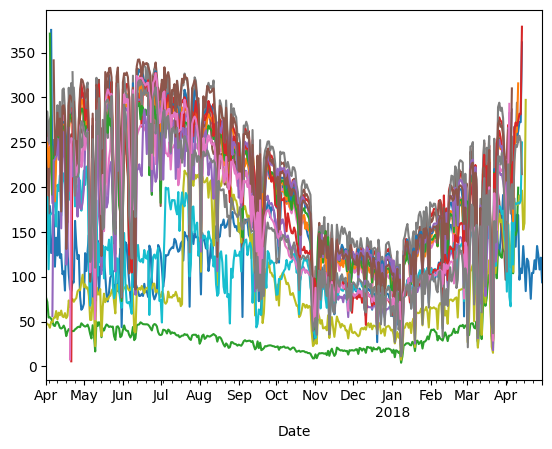

In [21]:
all_combined['phase3'].groupby('Site')['So'].plot()

# Prepare for IDW gap-filling, predictor calculation (based on BioCLIM variables)

In [22]:
# Print current directory
print('Current Directory: ' + os.getcwd())

# Define location of bioscan data
bioscan_file = main_folder + '/Data_Upon_Request/bioscan.xlsx'
print('Bioscan Data Directory: ' + bioscan_file)

Current Directory: /Users/teaganbaiotto/Mirror/Research/bioscan
Bioscan Data Directory: /Users/teaganbaiotto/Mirror/Research/bioscan/bioscan.xlsx


### Import BioSCAN collection site locations

In [23]:
# Get dataframe of sites and coordinates from bioscan data sheet
bioscan_locations = pd.read_excel(open(bioscan_file, 'rb'), sheet_name='Annual Combined All')[["Site", "Latitude", "Longitude"]]
bioscan_locations.index = bioscan_locations.iloc[:,0]
bioscan_locations = bioscan_locations.drop(columns="Site")
bioscan_locations = bioscan_locations[~bioscan_locations.index.duplicated(keep='first')]
bioscan_locations

Latitude  Longitude
Site                       
Site01  34.01707 -118.28868
Site03  34.03400 -118.28100
Site04  34.11800 -118.28400
Site05  34.09300 -118.27400
Site06  34.11600 -118.27900
...          ...        ...
Site59  33.93200 -118.25900
Site60  34.24700 -118.50800
Site61  34.24400 -118.57900
Site62  34.16300 -118.35600
Site63  33.95000 -118.18400

[62 rows x 2 columns]

### Distance matrix between sites

In [26]:
# Create dictionaries from bioscan site dataframe and met station dataframe for easy computing
bioscan_dict = bioscan_locations.to_dict(orient="index")

# for each site - met station combo, compute distance
for sample,bioscan_coord in bioscan_dict.items():
    # coordinates of bioscan site
    sample_coords = (bioscan_coord["Latitude"], bioscan_coord["Longitude"])
    
    for station,station_coord in bioscan_dict.items():
        # coordinates of met station
        station_coords = (station_coord["Latitude"], station_coord["Longitude"])
        # compute distance between site and met station coordinates in kilometers
        dist_to_station = geopy.distance.distance(sample_coords, station_coords).km
        # assign distance to dictionary
        bioscan_dict[sample][station] = dist_to_station

#convert distance dictionary to pandas df
dist_to_stations = pd.DataFrame(bioscan_dict).T.iloc[: , 2:]
dist_to_stations

Site01     Site03     Site04     Site05     Site06     Site07  \
Site01   0.000000   2.007413  11.203852   8.530765  11.009993   9.864209   
Site03   2.007413   0.000000   9.321710   6.576315   9.097620   7.860763   
Site04  11.203852   9.321710   0.000000   2.922586   0.511864   3.097394   
Site05   8.530765   6.576315   2.922586   0.000000   2.592638   1.885866   
Site06  11.009993   9.097620   0.511864   2.592638   0.000000   2.594004   
...           ...        ...        ...        ...        ...        ...   
Site59   9.826671  11.495231  20.760446  17.912210  20.493217  18.845982   
Site60  32.554115  31.568686  25.123182  27.518850  25.628731  28.220492   
Site61  36.753312  36.028941  30.576857  32.731890  31.088525  33.647245   
Site62  17.338456  15.895026   8.307564  10.840096   8.810129  11.403937   
Site63  12.202787  12.928092  20.797762  17.908094  20.396438  18.132596   

           Site08     Site09     Site10     Site11  ...     Site54     Site55  \
Site01   3.818772  10.422903   3.004692   6.096776  ...  37.695289  16.648526   
Site03   4.271214   8.419279   4.309267   4.315019  ...  37.139241  18.642249   
Site04  10.537384   4.132616  12.031075   5.143236  ...  32.397170  27.720067   
Site05   8.530812   3.068167   9.778510   2.808548  ...  34.363942  25.162163   
Site06  10.518162   3.621091  11.960096   5.004714  ...  32.907997  27.577703   
...           ...        ...        ...        ...  ...        ...        ...   
Site59  12.555791  19.025268  10.749835  15.808021  ...  46.046837   9.479358   
Site60  29.293391  29.189897  31.073011  27.878665  ...   9.655332  44.775503   
Site61  33.222711  34.702477  34.889772  32.700312  ...   3.422398  47.269572   
Site62  14.993664  12.366819  16.840356  11.741049  ...  24.464665  32.451721   
Site63  15.915900  17.824512  14.513991  16.757726  ...  49.897375  16.163352   

           Site56     Site57     Site58     Site59     Site60     Site61  \
Site01   6.996922  19.832170   3.541488   9.826671  32.554115  36.753312   
Site03   8.912656  18.641115   4.694233  11.495231  31.568686  36.028941   
Site04  18.199814  12.046040  11.990313  20.760446  25.123182  30.576857   
Site05  15.488925  14.341769   9.843496  17.912210  27.518850  32.731890   
Site06  17.998218  12.556956  11.944642  20.493217  25.628731  31.088525   
...           ...        ...        ...        ...        ...        ...   
Site59   3.764034  29.453689  11.238520   0.000000  41.820318  45.496180   
Site60  38.222481  13.184752  30.583000  41.820318   0.000000   6.548850   
Site61  41.784796  18.542459  34.350766  45.496180   6.548850   0.000000   
Site62  23.970370   3.972926  16.524009  27.143463  16.824500  22.430724   
Site63   9.808332  31.484144  15.106143   7.215385  44.488517  48.909612   

           Site62     Site63  
Site01  17.338456  12.202787  
Site03  15.895026  12.928092  
Site04   8.307564  20.797762  
Site05  10.840096  17.908094  
Site06   8.810129  20.396438  
...           ...        ...  
Site59  27.143463   7.215385  
Site60  16.824500  44.488517  
Site61  22.430724  48.909612  
Site62   0.000000  28.467226  
Site63  28.467226   0.000000  

[62 rows x 62 columns]

### Rank distances

In [27]:
# Rank the distances, assign 1 to lowerst value, n to highest
ranks = dist_to_stations.rank(axis=1, method='first')
ranks

Site01  Site03  Site04  Site05  Site06  Site07  Site08  Site09  \
Site01     1.0     2.0    24.0    16.0    23.0    20.0     6.0    21.0   
Site03     3.0     1.0    24.0    14.0    22.0    16.0     4.0    18.0   
Site04    31.0    28.0     1.0     4.0     2.0     6.0    30.0     8.0   
Site05    24.0    18.0     7.0     1.0     4.0     2.0    25.0     8.0   
Site06    31.0    27.0     2.0     4.0     1.0     6.0    30.0     7.0   
...        ...     ...     ...     ...     ...     ...     ...     ...   
Site59     8.0    11.0    33.0    24.0    32.0    25.0    12.0    26.0   
Site60    41.0    38.0    14.0    23.0    18.0    26.0    29.0    28.0   
Site61    38.0    37.0    17.0    23.0    19.0    27.0    25.0    30.0   
Site62    37.0    32.0     7.0    14.0     8.0    16.0    29.0    20.0   
Site63     5.0     7.0    35.0    23.0    32.0    24.0    16.0    21.0   

        Site10  Site11  ...  Site54  Site55  Site56  Site57  Site58  Site59  \
Site01     3.0    10.0  ...    53.0    38.0    12.0    44.0     5.0    19.0   
Site03     5.0     6.0  ...    53.0    43.0    21.0    42.0     7.0    26.0   
Site04    33.0    10.0  ...    51.0    49.0    39.0    34.0    32.0    40.0   
Site05    31.0     6.0  ...    53.0    47.0    36.0    35.0    32.0    40.0   
Site06    33.0    11.0  ...    51.0    49.0    39.0    34.0    32.0    41.0   
...        ...     ...  ...     ...     ...     ...     ...     ...     ...   
Site59     9.0    18.0  ...    55.0     6.0     2.0    47.0    10.0     1.0   
Site60    35.0    24.0  ...     5.0    49.0    45.0     7.0    33.0    46.0   
Site61    31.0    22.0  ...     3.0    47.0    44.0     7.0    28.0    46.0   
Site62    36.0    18.0  ...    43.0    51.0    42.0     3.0    34.0    46.0   
Site63    11.0    18.0  ...    57.0    17.0     3.0    48.0    13.0     2.0   

        Site60  Site61  Site62  Site63  
Site01    51.0    52.0    42.0    27.0  
Site03    51.0    52.0    37.0    30.0  
Site04    45.0    50.0    23.0    41.0  
Site05    49.0    52.0    33.0    39.0  
Site06    45.0    50.0    26.0    40.0  
...        ...     ...     ...     ...  
Site59    52.0    54.0    45.0     5.0  
Site60     1.0     2.0     8.0    48.0  
Site61     4.0     1.0     8.0    51.0  
Site62    35.0    41.0     1.0    48.0  
Site63    54.0    56.0    45.0     1.0  

[62 rows x 62 columns]

### Perform IDW gap-filling - one variable at a time

In [29]:
IDW_out_all_phases = {}

Var = 'So'

num_sites_IDW = 3
IDW_power = 1

for phase in ['phase1', 'phase2', 'phase3']:
    
    # Get percentage of sensors with data for each day
    nan_percentage = all_combined[phase].groupby(['Date']).count()/len(all_combined[phase]['Site'].unique())

    # Which dates are there less than 75% of sensors working?
    index_values = nan_percentage[nan_percentage[Var]<0.75].index
    print(index_values)

    # Make values nan if not enough data to interpolate
    all_combined[phase].loc[index_values, Var] = np.nan
    display(all_combined[phase].loc[index_values, Var])
    
    # Set start and end dates
    if phase == 'phase1':
        # Phase 1
        # Define start and end dates
        start_date = '2014-01-01'
        end_date = '2014-12-31'
    elif phase == 'phase2':
        # Phase 2
        # Define start and end dates
        start_date = '2015-11-01'
        end_date = '2016-10-31'
    elif phase == 'phase3':
        # Phase 3
        # Define start and end dates
        start_date = '2017-04-01'
        end_date = '2018-04-30'

    # Create range of all dates in bioscan data period
    date_range = pd.date_range(datetime.strptime(start_date, '%Y-%m-%d'), datetime.strptime(end_date, '%Y-%m-%d')).tolist()

    # create empty df to store outputs of IDW
    IDW_output = pd.DataFrame(columns=ranks.index.values.tolist(), index=date_range)
    display(IDW_output)

    # Loop through sites
    for site in all_combined[phase]['Site'].unique():
        print(site)
        
        # For every day, paste that site's data if not nan, IDW if value is nan
        for date in date_range:
            station_rank = 2.0 # start at 2 since.1 is self site
            num_selected = 0

            if not all_combined[phase][(all_combined[phase]['Site']==site) & (all_combined[phase].index==date)][Var].empty:
                if bool(all_combined[phase][(all_combined[phase]['Site']==site) & (all_combined[phase].index==date)][Var].notna()[0]):
                    IDW_output.loc[date,site] = all_combined[phase][(all_combined[phase]['Site']==site) & (all_combined[phase].index==date)][Var][0]
                else:
                    # create empty df for distance (weights) and met variable values to be put for each of x number of sites used for IDW
                    date_values = pd.DataFrame(columns=["distance", "value"])
                    while num_selected < num_sites_IDW and station_rank<len(all_combined[phase]['Site'].unique()):
                        my_station = ranks.loc[[site]].eq(station_rank, axis=0).idxmax(axis=1)
                        # skip this met station if value is nan for date
                        try:
                            if bool(all_combined[phase][(all_combined[phase]['Site']==my_station[0]) & (all_combined[phase].index==date)][Var].notna()[0]):
                                date_values = date_values.append({"distance": dist_to_stations.loc[site, my_station[0]], "value": all_combined[phase][(all_combined[phase]['Site']==my_station[0]) & (all_combined[phase].index==date)][Var][0]}, ignore_index=True)
                                num_selected += 1
                        except:
                            pass

                        station_rank += 1


                    # IDW Calculation for site, date combo
                    date_values['weight'] = 1/(date_values['distance']**(IDW_power))
                    date_values['IDW_top'] = date_values['value'].astype(float) * date_values['weight']
                    IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']

                    # store IDW value for site, date into IDW_output dataframe
                    IDW_output.loc[date,site] = IDW_value
                    print(date, site, IDW_value)
            else:
                # create empty df for distance (weights) and met variable values to be put for each of x number of sites used for IDW
                date_values = pd.DataFrame(columns=["distance", "value"])
                while num_selected < num_sites_IDW and station_rank<len(all_combined[phase]['Site'].unique()):
                    my_station = ranks.loc[[site]].eq(station_rank, axis=0).idxmax(axis=1)
                    # skip this met station if value is nan for date
                    try:
                        if bool(all_combined[phase][(all_combined[phase]['Site']==my_station[0]) & (all_combined[phase].index==date)][Var].notna()[0]):
                            date_values = date_values.append({"distance": dist_to_stations.loc[site, my_station[0]], "value": all_combined[phase][(all_combined[phase]['Site']==my_station[0]) & (all_combined[phase].index==date)][Var][0]}, ignore_index=True)
                            num_selected += 1
                    except:
                        pass

                    station_rank += 1


                # IDW Calculation for site, date combo
                date_values['weight'] = 1/(date_values['distance']**(IDW_power))
                date_values['IDW_top'] = date_values['value'].astype(float) * date_values['weight']
                IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']

                # store IDW value for site, date into IDW_output dataframe
                IDW_output.loc[date,site] = IDW_value
                print(date, site, IDW_value)

    IDW_out_all_phases[phase] = IDW_output
                   
IDW_out_all_phases

# Combine phases together
IDW_combined = pd.concat([IDW_out_all_phases['phase1'], IDW_out_all_phases['phase2'], IDW_out_all_phases['phase3']])

# Find which days are not present in all 3 phases data
which_days_missing_data = IDW_combined.groupby(IDW_combined.index.dayofyear).count().sum(axis=1)

# Get index values
index_values = which_days_missing_data.index[which_days_missing_data != which_days_missing_data.max()]

# Remove the data from all phases for a day if it is not present in all 3
IDW_combined[IDW_combined.index.dayofyear.isin(index_values)] == np.nan

# Final Calculations and exporting - variable dependent:
if Var == 'Te':
    pd.DataFrame({f'{Var}_mean': IDW_combined.mean()}).round(3).to_csv(os.path.join(main_folder, 'Data', f'ibutton_BioCLIM1_{Var}.csv'))
    (pd.DataFrame({f'{Var}_std': IDW_combined.std()}).round(3)*100).to_csv(os.path.join(main_folder, 'Data', f'ibutton_BioCLIM4_{Var}.csv'))
elif Var == 'RH':
    pd.DataFrame({f'{Var}_mean': IDW_combined.mean()}).round(3).to_csv(os.path.join(main_folder, 'Data', f'ibutton_{Var}.csv'))
    (pd.DataFrame({f'{Var}_std': IDW_combined.std()}).round(3)*100).to_csv(os.path.join(main_folder, 'Data', f'ibutton_{Var}_std.csv'))
elif Var == 'Tmax':
    IDW_combined.to_csv(os.path.join(main_folder, 'Data', f'ibutton_{Var}_RAW.csv'))
elif Var == 'Tmin':
    IDW_combined.to_csv(os.path.join(main_folder, 'Data', f'ibutton_{Var}_RAW.csv'))
elif Var == 'So':
    pd.DataFrame({f'{Var}_mean': IDW_combined.mean()}).round(3).to_csv(os.path.join(main_folder, 'Data', f'ibutton_{Var}.csv'))


DatetimeIndex([], dtype='datetime64[ns]', name='Date', freq=None)


Series([], Name: So, dtype: float64)

Site01 Site03 Site04 Site05 Site06 Site07 Site08 Site09 Site10  \
2014-01-01    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2014-01-02    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2014-01-03    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2014-01-04    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2014-01-05    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
...           ...    ...    ...    ...    ...    ...    ...    ...    ...   
2014-12-27    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2014-12-28    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2014-12-29    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2014-12-30    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2014-12-31    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

           Site11  ... Site54 Site55 Site56 Site57 Site58 Site59 Site60  \
2014-01-01    NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2014-01-02    NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2014-01-03    NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2014-01-04    NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2014-01-05    NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
...           ...  ...    ...    ...    ...    ...    ...    ...    ...   
2014-12-27    NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2014-12-28    NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2014-12-29    NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2014-12-30    NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2014-12-31    NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

           Site61 Site62 Site63  
2014-01-01    NaN    NaN    NaN  
2014-01-02    NaN    NaN    NaN  
2014-01-03    NaN    NaN    NaN  
2014-01-04    NaN    NaN    NaN  
2014-01-05    NaN    NaN    NaN  
...           ...    ...    ...  
2014-12-27    NaN    NaN    NaN  
2014-12-28    NaN    NaN    NaN  
2014-12-29    NaN    NaN    NaN  
2014-12-30    NaN    NaN    NaN  
2014-12-31    NaN    NaN    NaN  

[365 rows x 62 columns]

Site01
Site03
Site04
Site05
Site06
2014-01-03 00:00:00 Site06 29.92412788112933


/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  date_values = date_values.append({"distance": dist_to_stations.loc[site, my_station[0]], "value": all_combined[phase][(all_combined[phase]['Site']==my_station[0]) & (all_combined[phase].index==date)][Var][0]}, ignore_index=True)
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  date_values = date_values.append({"distance": dist_to_stations.loc[site, my_station[0]], "value": all_combined[phase][(all_combined[phase]['Site']==my_station[0]) & (all_combined[phase].index==date)][Var][0]}, ignore_index=True)
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:65: FutureWarning: The fram

Site07
Site08
2014-01-01 00:00:00 Site08 102.49405208901655
2014-01-02 00:00:00 Site08 106.50709184465492
2014-01-03 00:00:00 Site08 90.5988596358642
2014-01-04 00:00:00 Site08 82.4773843150424
2014-01-05 00:00:00 Site08 113.01068782336428
2014-01-06 00:00:00 Site08 111.84730351717747
2014-01-07 00:00:00 Site08 62.131278706762295
2014-01-08 00:00:00 Site08 100.20032244306955
2014-01-09 00:00:00 Site08 76.93528258128809
2014-01-10 00:00:00 Site08 103.02451821648226
2014-01-11 00:00:00 Site08 101.67076897215712
2014-01-12 00:00:00 Site08 81.35726917567231
2014-01-13 00:00:00 Site08 112.96943070026191
2014-01-14 00:00:00 Site08 113.26235236529133
2014-01-15 00:00:00 Site08 113.67456488011301
2014-01-16 00:00:00 Site08 105.50143203860807
2014-01-17 00:00:00 Site08 117.16483697582264
2014-01-18 00:00:00 Site08 111.76022124400734


/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  date_values = date_values.append({"distance": dist_to_stations.loc[site, my_station[0]], "value": all_combined[phase][(all_combined[phase]['Site']==my_station[0]) & (all_combined[phase].index==date)][Var][0]}, ignore_index=True)
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  date_values = date_values.append({"distance": dist_to_stations.loc[site, my_station[0]], "value": all_combined[phase][(all_combined[phase]['Site']==my_station[0]) & (all_combined[phase].index==date)][Var][0]}, ignore_index=True)
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:65: FutureWarning: The fram

2014-01-19 00:00:00 Site08 101.56814295684244
2014-01-20 00:00:00 Site08 117.1524515288327
2014-01-21 00:00:00 Site08 55.31832630733195
2014-01-22 00:00:00 Site08 116.49821187609909
2014-01-23 00:00:00 Site08 98.82031075825644
2014-01-24 00:00:00 Site08 49.95530666637197
2014-01-25 00:00:00 Site08 106.2999300673561
2014-01-26 00:00:00 Site08 60.10721856910856
2014-01-27 00:00:00 Site08 110.50362220070133
2014-01-28 00:00:00 Site08 103.58238519843846
2014-01-29 00:00:00 Site08 110.41058955698672
2014-01-30 00:00:00 Site08 37.64986398184164
2014-01-31 00:00:00 Site08 89.60861050015124
2014-02-01 00:00:00 Site08 128.53530605350542
2014-02-02 00:00:00 Site08 84.13327553805127
2014-02-03 00:00:00 Site08 130.63216068452567
2014-02-04 00:00:00 Site08 90.97178771424237
2014-02-05 00:00:00 Site08 130.82226506335846
2014-02-06 00:00:00 Site08 39.68180099765764
2014-02-07 00:00:00 Site08 87.19654957023543


/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  date_values = date_values.append({"distance": dist_to_stations.loc[site, my_station[0]], "value": all_combined[phase][(all_combined[phase]['Site']==my_station[0]) & (all_combined[phase].index==date)][Var][0]}, ignore_index=True)
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  date_values = date_values.append({"distance": dist_to_stations.loc[site, my_station[0]], "value": all_combined[phase][(all_combined[phase]['Site']==my_station[0]) & (all_combined[phase].index==date)][Var][0]}, ignore_index=True)
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:65: FutureWarning: The fram

2014-02-08 00:00:00 Site08 117.08314963904506
2014-02-09 00:00:00 Site08 91.34828954444177
2014-02-10 00:00:00 Site08 136.39614517104567
2014-02-11 00:00:00 Site08 118.00132027211394
2014-02-12 00:00:00 Site08 135.42261402140963
2014-02-13 00:00:00 Site08 139.15587868565143
2014-02-14 00:00:00 Site08 145.88844844240904
2014-02-15 00:00:00 Site08 105.53160429157987
2014-02-16 00:00:00 Site08 133.57256858088837
2014-02-17 00:00:00 Site08 142.31570834180746
2014-02-18 00:00:00 Site08 105.77491940596683
2014-02-19 00:00:00 Site08 147.42406186935514
2014-02-20 00:00:00 Site08 145.4388615410857
2014-02-21 00:00:00 Site08 149.29240784181826
2014-02-22 00:00:00 Site08 128.57300147194738


/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  date_values = date_values.append({"distance": dist_to_stations.loc[site, my_station[0]], "value": all_combined[phase][(all_combined[phase]['Site']==my_station[0]) & (all_combined[phase].index==date)][Var][0]}, ignore_index=True)
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  date_values = date_values.append({"distance": dist_to_stations.loc[site, my_station[0]], "value": all_combined[phase][(all_combined[phase]['Site']==my_station[0]) & (all_combined[phase].index==date)][Var][0]}, ignore_index=True)
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:65: FutureWarning: The fram

Site09
Site10
Site11
2014-01-01 00:00:00 Site11 70.63867433964212
2014-01-02 00:00:00 Site11 71.75041033050643
2014-01-03 00:00:00 Site11 64.6615826877708
2014-01-04 00:00:00 Site11 57.89519605139837
2014-01-05 00:00:00 Site11 73.28987922545494
2014-01-06 00:00:00 Site11 70.61931384343677
2014-01-07 00:00:00 Site11 46.558147364004476
2014-01-08 00:00:00 Site11 70.84462015673071
2014-01-09 00:00:00 Site11 65.6233730936181
2014-01-10 00:00:00 Site11 70.02292661969635
2014-01-11 00:00:00 Site11 68.84678632120635
2014-01-12 00:00:00 Site11 59.52320834379082
2014-01-13 00:00:00 Site11 74.81283662293674
2014-01-14 00:00:00 Site11 76.41562782293464
2014-01-15 00:00:00 Site11 76.19760806544433
2014-01-16 00:00:00 Site11 76.20001411669256
2014-01-17 00:00:00 Site11 79.57264682854283


/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  date_values = date_values.append({"distance": dist_to_stations.loc[site, my_station[0]], "value": all_combined[phase][(all_combined[phase]['Site']==my_station[0]) & (all_combined[phase].index==date)][Var][0]}, ignore_index=True)
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  date_values = date_values.append({"distance": dist_to_stations.loc[site, my_station[0]], "value": all_combined[phase][(all_combined[phase]['Site']==my_station[0]) & (all_combined[phase].index==date)][Var][0]}, ignore_index=True)
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:65: FutureWarning: The fram

/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  date_values = date_values.append({"distance": dist_to_stations.loc[site, my_station[0]], "value": all_combined[phase][(all_combined[phase]['Site']==my_station[0]) & (all_combined[phase].index==date)][Var][0]}, ignore_index=True)
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  date_values = date_values.append({"distance": dist_to_stations.loc[site, my_station[0]], "value": all_combined[phase][(all_combined[phase]['Site']==my_station[0]) & (all_combined[phase].index==date)][Var][0]}, ignore_index=True)
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:65: FutureWarning: The fram

2014-02-20 00:00:00 Site11 112.51402358063379
2014-02-21 00:00:00 Site11 116.25852722533574
2014-03-06 00:00:00 Site11 132.35592934310907
2014-03-07 00:00:00 Site11 115.6789519724229
2014-03-08 00:00:00 Site11 153.78866072981927
2014-03-09 00:00:00 Site11 154.5613719790781
2014-03-10 00:00:00 Site11 153.46116330649645
2014-03-11 00:00:00 Site11 112.11890831111334
2014-03-12 00:00:00 Site11 154.79777607833353
2014-03-13 00:00:00 Site11 150.35060238331116
2014-03-14 00:00:00 Site11 157.3839479033679
2014-03-15 00:00:00 Site11 160.93834891397094
2014-03-16 00:00:00 Site11 165.5016913021424
2014-03-17 00:00:00 Site11 163.33263292772838
2014-03-18 00:00:00 Site11 160.2492168265896
2014-03-19 00:00:00 Site11 164.56164740494802
2014-03-20 00:00:00 Site11 148.26046334158204
2014-03-21 00:00:00 Site11 128.04354140986186
2014-03-22 00:00:00 Site11 137.6160240271049
2014-03-23 00:00:00 Site11 149.7323866882209
2014-03-24 00:00:00 Site11 114.05068183607332
2014-03-25 00:00:00 Site11 73.48781893272

/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  date_values = date_values.append({"distance": dist_to_stations.loc[site, my_station[0]], "value": all_combined[phase][(all_combined[phase]['Site']==my_station[0]) & (all_combined[phase].index==date)][Var][0]}, ignore_index=True)
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  date_values = date_values.append({"distance": dist_to_stations.loc[site, my_station[0]], "value": all_combined[phase][(all_combined[phase]['Site']==my_station[0]) & (all_combined[phase].index==date)][Var][0]}, ignore_index=True)
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:65: FutureWarning: The fram

2014-03-26 00:00:00 Site11 162.4467739247752
2014-03-27 00:00:00 Site11 161.47569519794772
2014-03-28 00:00:00 Site11 160.87006021331982
2014-03-29 00:00:00 Site11 155.74905864020252
2014-03-30 00:00:00 Site11 197.32139375945619
2014-03-31 00:00:00 Site11 180.6696741719291
2014-04-01 00:00:00 Site11 189.56849628380968
2014-04-02 00:00:00 Site11 148.18873243302497
2014-04-03 00:00:00 Site11 202.79206282872872
2014-04-04 00:00:00 Site11 188.24177011546004
2014-04-05 00:00:00 Site11 204.31298064316582
2014-04-06 00:00:00 Site11 212.1067215306153
2014-04-07 00:00:00 Site11 216.62976088054833
2014-04-08 00:00:00 Site11 209.45115527310182
2014-04-09 00:00:00 Site11 217.04935769779934
2014-04-10 00:00:00 Site11 167.51314998186277
2014-04-11 00:00:00 Site11 214.99090592407285
2014-04-12 00:00:00 Site11 155.06076337136787
2014-04-13 00:00:00 Site11 152.94607905292716
2014-04-14 00:00:00 Site11 215.34435887817506
2014-04-15 00:00:00 Site11 217.51132744242233
2014-04-16 00:00:00 Site11 209.557730

/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  date_values = date_values.append({"distance": dist_to_stations.loc[site, my_station[0]], "value": all_combined[phase][(all_combined[phase]['Site']==my_station[0]) & (all_combined[phase].index==date)][Var][0]}, ignore_index=True)
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  date_values = date_values.append({"distance": dist_to_stations.loc[site, my_station[0]], "value": all_combined[phase][(all_combined[phase]['Site']==my_station[0]) & (all_combined[phase].index==date)][Var][0]}, ignore_index=True)
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:65: FutureWarning: The fram

2014-04-20 00:00:00 Site11 213.0726059019871
2014-04-21 00:00:00 Site11 213.72136520017108
2014-04-22 00:00:00 Site11 189.0430279785456
2014-04-23 00:00:00 Site11 206.29348746938786
2014-04-24 00:00:00 Site11 218.7249234330129
2014-04-25 00:00:00 Site11 123.85253578292772
2014-04-26 00:00:00 Site11 217.372171704902
2014-04-27 00:00:00 Site11 196.41013700830405
2014-04-28 00:00:00 Site11 227.73557563896196
2014-04-29 00:00:00 Site11 231.20589317668933
2014-04-30 00:00:00 Site11 233.83754613373176
2014-05-01 00:00:00 Site11 233.62432997657584
2014-05-02 00:00:00 Site11 234.98797199483968
2014-05-03 00:00:00 Site11 214.47541291986664
Site12
Site13
Site14
2014-04-11 00:00:00 Site14 184.83518467536618
2014-04-12 00:00:00 Site14 132.95577530845634
2014-04-13 00:00:00 Site14 125.72939162637027


/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  date_values = date_values.append({"distance": dist_to_stations.loc[site, my_station[0]], "value": all_combined[phase][(all_combined[phase]['Site']==my_station[0]) & (all_combined[phase].index==date)][Var][0]}, ignore_index=True)
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  date_values = date_values.append({"distance": dist_to_stations.loc[site, my_station[0]], "value": all_combined[phase][(all_combined[phase]['Site']==my_station[0]) & (all_combined[phase].index==date)][Var][0]}, ignore_index=True)
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:65: FutureWarning: The fram

2014-04-14 00:00:00 Site14 182.31642692214336
2014-04-15 00:00:00 Site14 181.64354215972668
2014-04-16 00:00:00 Site14 171.56241477190397
2014-04-17 00:00:00 Site14 114.59685242511114
2014-04-18 00:00:00 Site14 124.36048016924266
2014-04-19 00:00:00 Site14 155.47122610835189
2014-04-20 00:00:00 Site14 168.5749371117679
2014-04-21 00:00:00 Site14 164.9877741653105
2014-04-22 00:00:00 Site14 142.42606036682753
2014-04-23 00:00:00 Site14 159.81830907580382
2014-04-24 00:00:00 Site14 171.51485494576903
2014-04-25 00:00:00 Site14 90.65917673277006
2014-04-26 00:00:00 Site14 165.70473491830637
2014-04-27 00:00:00 Site14 153.22421889318827
2014-04-28 00:00:00 Site14 176.33954899042683
2014-04-29 00:00:00 Site14 180.79425798738765
2014-04-30 00:00:00 Site14 182.23233949017705
2014-05-01 00:00:00 Site14 179.3843876921148
2014-05-02 00:00:00 Site14 183.09222356202392
2014-05-03 00:00:00 Site14 167.99836429227415
Site15
Site16
2014-01-01 00:00:00 Site16 79.97381382354186
2014-01-02 00:00:00 Site1

/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  date_values = date_values.append({"distance": dist_to_stations.loc[site, my_station[0]], "value": all_combined[phase][(all_combined[phase]['Site']==my_station[0]) & (all_combined[phase].index==date)][Var][0]}, ignore_index=True)
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  date_values = date_values.append({"distance": dist_to_stations.loc[site, my_station[0]], "value": all_combined[phase][(all_combined[phase]['Site']==my_station[0]) & (all_combined[phase].index==date)][Var][0]}, ignore_index=True)
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:65: FutureWarning: The fram

Site17
Site18
Site19
Site20
Site21
2014-01-01 00:00:00 Site21 58.94459177168094
2014-01-02 00:00:00 Site21 58.25352793445495
2014-01-03 00:00:00 Site21 37.0428502579523
2014-01-04 00:00:00 Site21 52.40489743702561
2014-01-05 00:00:00 Site21 62.4066111258735
2014-01-06 00:00:00 Site21 63.00302547342098
2014-01-07 00:00:00 Site21 46.59543931060747
2014-01-08 00:00:00 Site21 58.67326713547314
2014-01-09 00:00:00 Site21 57.27884300610559
2014-01-10 00:00:00 Site21 60.51890581477258
2014-01-11 00:00:00 Site21 61.589918594286836
2014-01-12 00:00:00 Site21 52.6671472235295
2014-01-13 00:00:00 Site21 64.42918429421486
2014-01-14 00:00:00 Site21 65.33378848732413
2014-01-15 00:00:00 Site21 65.09220168505169
2014-01-16 00:00:00 Site21 66.53470307533713
2014-01-17 00:00:00 Site21 65.99873158738802
2014-01-18 00:00:00 Site21 65.44680110405153


/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  date_values = date_values.append({"distance": dist_to_stations.loc[site, my_station[0]], "value": all_combined[phase][(all_combined[phase]['Site']==my_station[0]) & (all_combined[phase].index==date)][Var][0]}, ignore_index=True)
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  date_values = date_values.append({"distance": dist_to_stations.loc[site, my_station[0]], "value": all_combined[phase][(all_combined[phase]['Site']==my_station[0]) & (all_combined[phase].index==date)][Var][0]}, ignore_index=True)
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:65: FutureWarning: The fram

/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  date_values = date_values.append({"distance": dist_to_stations.loc[site, my_station[0]], "value": all_combined[phase][(all_combined[phase]['Site']==my_station[0]) & (all_combined[phase].index==date)][Var][0]}, ignore_index=True)
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  date_values = date_values.append({"distance": dist_to_stations.loc[site, my_station[0]], "value": all_combined[phase][(all_combined[phase]['Site']==my_station[0]) & (all_combined[phase].index==date)][Var][0]}, ignore_index=True)
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:65: FutureWarning: The fram

2014-01-19 00:00:00 Site21 66.28743543793561
2014-01-20 00:00:00 Site21 67.18521129164202
2014-01-21 00:00:00 Site21 52.13668826237404
2014-01-22 00:00:00 Site21 64.7905724000051
2014-01-23 00:00:00 Site21 62.83177831799703
2014-01-24 00:00:00 Site21 44.96693882170168
2014-01-25 00:00:00 Site21 69.09888421038674
2014-01-26 00:00:00 Site21 53.91181131239376
2014-01-27 00:00:00 Site21 69.55042601239285
2014-01-28 00:00:00 Site21 67.3388032487472
2014-01-29 00:00:00 Site21 70.22089851664097
2014-01-30 00:00:00 Site21 30.335903486226602
2014-01-31 00:00:00 Site21 63.817047952000124
2014-02-01 00:00:00 Site21 79.5862858398021
Site22
Site23
Site24
Site25
Site26
Site27
Site28
Site29
Site30


/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  date_values = date_values.append({"distance": dist_to_stations.loc[site, my_station[0]], "value": all_combined[phase][(all_combined[phase]['Site']==my_station[0]) & (all_combined[phase].index==date)][Var][0]}, ignore_index=True)
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  date_values = date_values.append({"distance": dist_to_stations.loc[site, my_station[0]], "value": all_combined[phase][(all_combined[phase]['Site']==my_station[0]) & (all_combined[phase].index==date)][Var][0]}, ignore_index=True)
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:65: FutureWarning: The fram

2014-07-18 00:00:00 Site30 256.2398045677253
2014-07-19 00:00:00 Site30 115.09812631488258
2014-07-20 00:00:00 Site30 212.97834041165538
2014-07-21 00:00:00 Site30 262.954068608877
2014-07-22 00:00:00 Site30 269.2230016955246
2014-07-23 00:00:00 Site30 269.7504073927233
2014-07-24 00:00:00 Site30 274.2349275149344
2014-07-25 00:00:00 Site30 243.3585399347665
2014-07-26 00:00:00 Site30 257.7707338212944
2014-07-27 00:00:00 Site30 182.00213534125226
2014-07-28 00:00:00 Site30 180.52249392441425
2014-07-29 00:00:00 Site30 208.60245588620973
2014-07-30 00:00:00 Site30 230.35092083143135
2014-07-31 00:00:00 Site30 247.56954207570436
2014-08-01 00:00:00 Site30 248.83912833538272
2014-08-02 00:00:00 Site30 146.77702890709062
2014-08-03 00:00:00 Site30 155.88936124703605
2014-08-04 00:00:00 Site30 246.84626735851126
2014-08-05 00:00:00 Site30 259.9852965948075
2014-08-06 00:00:00 Site30 248.85311337194813
2014-08-07 00:00:00 Site30 243.65015926135138
2014-08-08 00:00:00 Site30 247.021070364237

Date
2016-10-20   NaN
2016-10-20   NaN
2016-10-20   NaN
2016-10-20   NaN
2016-10-20   NaN
2016-10-20   NaN
2016-10-20   NaN
2016-10-20   NaN
2016-10-20   NaN
2016-10-20   NaN
2016-10-20   NaN
2016-10-20   NaN
2016-10-21   NaN
2016-10-21   NaN
2016-10-21   NaN
2016-10-21   NaN
2016-10-21   NaN
2016-10-21   NaN
2016-10-21   NaN
2016-10-21   NaN
2016-10-22   NaN
2016-10-22   NaN
2016-10-22   NaN
2016-10-22   NaN
2016-10-22   NaN
2016-10-22   NaN
2016-10-22   NaN
2016-10-23   NaN
2016-10-23   NaN
2016-10-23   NaN
2016-10-23   NaN
2016-10-23   NaN
2016-10-24   NaN
2016-10-24   NaN
2016-10-24   NaN
2016-10-24   NaN
2016-10-24   NaN
2016-10-25   NaN
2016-10-25   NaN
2016-10-25   NaN
2016-10-25   NaN
2016-10-25   NaN
2016-10-26   NaN
2016-10-26   NaN
2016-10-27   NaN
Name: So, dtype: float64

Site01 Site03 Site04 Site05 Site06 Site07 Site08 Site09 Site10  \
2015-11-01    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2015-11-02    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2015-11-03    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2015-11-04    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2015-11-05    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
...           ...    ...    ...    ...    ...    ...    ...    ...    ...   
2016-10-27    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2016-10-28    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2016-10-29    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2016-10-30    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2016-10-31    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

           Site11  ... Site54 Site55 Site56 Site57 Site58 Site59 Site60  \
2015-11-01    NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2015-11-02    NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2015-11-03    NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2015-11-04    NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2015-11-05    NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
...           ...  ...    ...    ...    ...    ...    ...    ...    ...   
2016-10-27    NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2016-10-28    NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2016-10-29    NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2016-10-30    NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2016-10-31    NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

           Site61 Site62 Site63  
2015-11-01    NaN    NaN    NaN  
2015-11-02    NaN    NaN    NaN  
2015-11-03    NaN    NaN    NaN  
2015-11-04    NaN    NaN    NaN  
2015-11-05    NaN    NaN    NaN  
...           ...    ...    ...  
2016-10-27    NaN    NaN    NaN  
2016-10-28    NaN    NaN    NaN  
2016-10-29    NaN    NaN    NaN  
2016-10-30    NaN    NaN    NaN  
2016-10-31    NaN    NaN    NaN  

[366 rows x 62 columns]

Site01
2015-11-01 00:00:00 Site01 nan
2015-11-02 00:00:00 Site01 nan
2015-11-03 00:00:00 Site01 nan
2015-11-04 00:00:00 Site01 nan
2015-11-05 00:00:00 Site01 nan
2015-11-06 00:00:00 Site01 nan


/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
 

2016-10-20 00:00:00 Site01 nan
2016-10-21 00:00:00 Site01 nan
2016-10-22 00:00:00 Site01 nan
2016-10-23 00:00:00 Site01 nan
2016-10-24 00:00:00 Site01 nan
2016-10-25 00:00:00 Site01 nan
2016-10-26 00:00:00 Site01 nan
2016-10-27 00:00:00 Site01 nan
2016-10-28 00:00:00 Site01 nan
2016-10-29 00:00:00 Site01 nan
2016-10-30 00:00:00 Site01 nan
2016-10-31 00:00:00 Site01 nan
Site07


/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:76: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:76: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:76: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:76: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:76: RuntimeWarning: invalid value encountered in scalar divide
  IDW_

2016-10-20 00:00:00 Site07 nan
2016-10-21 00:00:00 Site07 nan
2016-10-22 00:00:00 Site07 nan
2016-10-23 00:00:00 Site07 nan
2016-10-24 00:00:00 Site07 nan
2016-10-25 00:00:00 Site07 nan
2016-10-26 00:00:00 Site07 nan
2016-10-27 00:00:00 Site07 nan
2016-10-28 00:00:00 Site07 nan
2016-10-29 00:00:00 Site07 nan
2016-10-30 00:00:00 Site07 nan
2016-10-31 00:00:00 Site07 nan
Site32


/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:76: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:76: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:76: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
  ID

2016-10-20 00:00:00 Site32 nan
2016-10-21 00:00:00 Site32 nan
2016-10-22 00:00:00 Site32 nan
2016-10-23 00:00:00 Site32 nan
2016-10-24 00:00:00 Site32 nan
2016-10-25 00:00:00 Site32 nan
2016-10-26 00:00:00 Site32 nan
2016-10-27 00:00:00 Site32 nan
2016-10-28 00:00:00 Site32 nan
2016-10-29 00:00:00 Site32 nan
2016-10-30 00:00:00 Site32 nan
2016-10-31 00:00:00 Site32 nan
Site33


/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:76: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:76: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:76: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:76: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:76: RuntimeWarning: invalid value encountered in scalar divide
  IDW_

2016-10-20 00:00:00 Site33 nan
2016-10-21 00:00:00 Site33 nan
2016-10-22 00:00:00 Site33 nan
2016-10-23 00:00:00 Site33 nan
2016-10-24 00:00:00 Site33 nan
2016-10-25 00:00:00 Site33 nan
2016-10-26 00:00:00 Site33 nan
2016-10-27 00:00:00 Site33 nan
2016-10-28 00:00:00 Site33 nan
2016-10-29 00:00:00 Site33 nan
2016-10-30 00:00:00 Site33 nan
2016-10-31 00:00:00 Site33 nan
Site34


/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:76: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:76: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:76: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:76: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:76: RuntimeWarning: invalid value encountered in scalar divide
  IDW_

2016-10-20 00:00:00 Site34 nan
2016-10-21 00:00:00 Site34 nan
2016-10-22 00:00:00 Site34 nan
2016-10-23 00:00:00 Site34 nan
2016-10-24 00:00:00 Site34 nan
2016-10-25 00:00:00 Site34 nan
2016-10-26 00:00:00 Site34 nan
2016-10-27 00:00:00 Site34 nan
2016-10-28 00:00:00 Site34 nan
2016-10-29 00:00:00 Site34 nan
2016-10-30 00:00:00 Site34 nan
2016-10-31 00:00:00 Site34 nan
Site35


/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:76: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:76: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:76: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:76: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:76: RuntimeWarning: invalid value encountered in scalar divide
  IDW_

2016-10-20 00:00:00 Site35 nan
2016-10-21 00:00:00 Site35 nan
2016-10-22 00:00:00 Site35 nan
2016-10-23 00:00:00 Site35 nan
2016-10-24 00:00:00 Site35 nan
2016-10-25 00:00:00 Site35 nan
2016-10-26 00:00:00 Site35 nan
2016-10-27 00:00:00 Site35 nan
2016-10-28 00:00:00 Site35 nan
2016-10-29 00:00:00 Site35 nan
2016-10-30 00:00:00 Site35 nan
2016-10-31 00:00:00 Site35 nan
Site36
2015-11-01 00:00:00 Site36 83.94956800954706
2015-11-02 00:00:00 Site36 71.81321546563082


/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  date_values = date_values.append({"distance": dist_to_stations.loc[site, my_station[0]], "value": all_combined[phase][(all_combined[phase]['Site']==my_station[0]) & (all_combined[phase].index==date)][Var][0]}, ignore_index=True)
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  date_values = date_values.append({"distance": dist_to_stations.loc[site, my_station[0]], "value": all_combined[phase][(all_combined[phase]['Site']==my_station[0]) & (all_combined[phase].index==date)][Var][0]}, ignore_index=True)
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:65: FutureWarning: The fram

2016-08-17 00:00:00 Site36 122.88810280198673
2016-08-18 00:00:00 Site36 127.68441072457175
2016-08-19 00:00:00 Site36 133.9659519038886
2016-08-20 00:00:00 Site36 146.55457508843398
2016-08-21 00:00:00 Site36 131.8370806631736
2016-08-22 00:00:00 Site36 133.66180741365633
2016-08-23 00:00:00 Site36 144.99601143039044
2016-08-24 00:00:00 Site36 145.47658721585012
2016-08-25 00:00:00 Site36 147.442772849712
2016-08-26 00:00:00 Site36 122.14024652115629
2016-08-27 00:00:00 Site36 124.90989963827907
2016-08-28 00:00:00 Site36 139.41690496755163
2016-08-29 00:00:00 Site36 143.6112829065907
2016-08-30 00:00:00 Site36 141.7129816750564
2016-08-31 00:00:00 Site36 141.12120332794305
2016-09-01 00:00:00 Site36 144.39992481640652
2016-09-02 00:00:00 Site36 143.3978780035256
2016-09-03 00:00:00 Site36 135.00016355878054
2016-09-04 00:00:00 Site36 122.93002834035372
2016-09-05 00:00:00 Site36 127.50306300669764
2016-09-06 00:00:00 Site36 140.43219107944935
2016-09-07 00:00:00 Site36 142.0645143222

/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  date_values = date_values.append({"distance": dist_to_stations.loc[site, my_station[0]], "value": all_combined[phase][(all_combined[phase]['Site']==my_station[0]) & (all_combined[phase].index==date)][Var][0]}, ignore_index=True)
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  date_values = date_values.append({"distance": dist_to_stations.loc[site, my_station[0]], "value": all_combined[phase][(all_combined[phase]['Site']==my_station[0]) & (all_combined[phase].index==date)][Var][0]}, ignore_index=True)
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:65: FutureWarning: The fram

2016-09-21 00:00:00 Site36 95.27036210517821
2016-09-22 00:00:00 Site36 89.78863295091884
2016-09-23 00:00:00 Site36 113.8611257003957
2016-09-24 00:00:00 Site36 114.23477525086913
2016-09-25 00:00:00 Site36 115.59372400535307
2016-09-26 00:00:00 Site36 101.58154340148496
2016-09-27 00:00:00 Site36 97.39070895025215
2016-09-28 00:00:00 Site36 102.2732176396282
2016-09-29 00:00:00 Site36 104.39143722052152
2016-09-30 00:00:00 Site36 102.63020527991958
2016-10-01 00:00:00 Site36 104.14356872907973
2016-10-02 00:00:00 Site36 107.1012001221417
2016-10-03 00:00:00 Site36 92.9759894414202
2016-10-04 00:00:00 Site36 97.71749853086753
2016-10-05 00:00:00 Site36 97.10126780968668
2016-10-06 00:00:00 Site36 99.43612500847162
2016-10-07 00:00:00 Site36 93.02980868168778
2016-10-08 00:00:00 Site36 92.91104780636024
2016-10-09 00:00:00 Site36 91.86790712602043
2016-10-10 00:00:00 Site36 88.95377474314287
2016-10-11 00:00:00 Site36 85.61244003212657
2016-10-12 00:00:00 Site36 60.39332288193256
2016-

/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
 

2016-10-22 00:00:00 Site36 nan
2016-10-23 00:00:00 Site36 nan
2016-10-24 00:00:00 Site36 nan
2016-10-25 00:00:00 Site36 nan
2016-10-26 00:00:00 Site36 nan
2016-10-27 00:00:00 Site36 nan
2016-10-28 00:00:00 Site36 nan
2016-10-29 00:00:00 Site36 nan
2016-10-30 00:00:00 Site36 nan
2016-10-31 00:00:00 Site36 nan
Site37


/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:76: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
  

2016-10-20 00:00:00 Site37 nan
2016-10-21 00:00:00 Site37 nan
2016-10-22 00:00:00 Site37 nan
2016-10-23 00:00:00 Site37 nan
2016-10-24 00:00:00 Site37 nan
2016-10-25 00:00:00 Site37 nan
2016-10-26 00:00:00 Site37 nan
2016-10-27 00:00:00 Site37 nan
2016-10-28 00:00:00 Site37 nan
2016-10-29 00:00:00 Site37 nan
2016-10-30 00:00:00 Site37 nan
2016-10-31 00:00:00 Site37 nan
Site38


/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  date_values = date_values.append({"distance": dist_to_stations.loc[site, my_station[0]], "value": all_combined[phase][(all_combined[phase]['Site']==my_station[0]) & (all_combined[phase].index==date)][Var][0]}, ignore_index=True)
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  date_values = date_values.append({"distance": dist_to_stations.loc[site, my_station[0]], "value": all_combined[phase][(all_combined[phase]['Site']==my_station[0]) & (all_combined[phase].index==date)][Var][0]}, ignore_index=True)
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:65: FutureWarning: The fram

2016-01-20 00:00:00 Site38 86.18685452579996
2016-01-21 00:00:00 Site38 100.59035684234271
2016-01-22 00:00:00 Site38 83.91185250023953
2016-01-23 00:00:00 Site38 56.250144576277414
2016-01-24 00:00:00 Site38 106.96865105962455
2016-01-25 00:00:00 Site38 108.50145273906041
2016-01-26 00:00:00 Site38 113.56284290184094
2016-01-27 00:00:00 Site38 86.61682631882213
2016-01-28 00:00:00 Site38 114.5566445752426
2016-01-29 00:00:00 Site38 105.31325560685109
2016-01-30 00:00:00 Site38 68.31914875308385
2016-01-31 00:00:00 Site38 31.308632651922245
2016-02-01 00:00:00 Site38 122.56519890044004
2016-02-02 00:00:00 Site38 120.57293695154449
2016-02-03 00:00:00 Site38 122.02723368650557
2016-02-04 00:00:00 Site38 125.28571637078629
2016-02-05 00:00:00 Site38 128.96404541228486
2016-02-06 00:00:00 Site38 131.04995505681214
2016-02-07 00:00:00 Site38 132.48150618526645
2016-02-08 00:00:00 Site38 133.74604609528487
2016-02-09 00:00:00 Site38 139.41082770011653
2016-02-10 00:00:00 Site38 134.33254432

/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  date_values = date_values.append({"distance": dist_to_stations.loc[site, my_station[0]], "value": all_combined[phase][(all_combined[phase]['Site']==my_station[0]) & (all_combined[phase].index==date)][Var][0]}, ignore_index=True)
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  date_values = date_values.append({"distance": dist_to_stations.loc[site, my_station[0]], "value": all_combined[phase][(all_combined[phase]['Site']==my_station[0]) & (all_combined[phase].index==date)][Var][0]}, ignore_index=True)
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:65: FutureWarning: The fram

2016-02-23 00:00:00 Site38 157.98325583566526
2016-02-24 00:00:00 Site38 163.3799625842012
2016-02-25 00:00:00 Site38 166.81940757525143
2016-02-26 00:00:00 Site38 155.7582487557192
2016-02-27 00:00:00 Site38 158.18047039200167
2016-02-28 00:00:00 Site38 152.20817575722862
2016-02-29 00:00:00 Site38 164.76795010726954
2016-03-01 00:00:00 Site38 166.03110739074685
2016-03-02 00:00:00 Site38 158.6934107650733
2016-03-03 00:00:00 Site38 146.96479004836
2016-03-04 00:00:00 Site38 138.74035186451536
2016-03-05 00:00:00 Site38 90.92696023693614
2016-03-06 00:00:00 Site38 125.57578531048807
2016-03-07 00:00:00 Site38 70.01969396936711
2016-03-08 00:00:00 Site38 177.3219995514613
2016-03-09 00:00:00 Site38 173.99177022440503
2016-03-10 00:00:00 Site38 168.8792395970796
2016-03-11 00:00:00 Site38 123.55980871239052
2016-03-12 00:00:00 Site38 178.78271009388368
2016-03-13 00:00:00 Site38 132.58679592026405
2016-03-14 00:00:00 Site38 115.87469386671508
2016-03-15 00:00:00 Site38 184.8378142118093

/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  date_values = date_values.append({"distance": dist_to_stations.loc[site, my_station[0]], "value": all_combined[phase][(all_combined[phase]['Site']==my_station[0]) & (all_combined[phase].index==date)][Var][0]}, ignore_index=True)
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  date_values = date_values.append({"distance": dist_to_stations.loc[site, my_station[0]], "value": all_combined[phase][(all_combined[phase]['Site']==my_station[0]) & (all_combined[phase].index==date)][Var][0]}, ignore_index=True)
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:65: FutureWarning: The fram

2016-03-28 00:00:00 Site38 132.1464059050415
2016-03-29 00:00:00 Site38 148.74761808409428
2016-03-30 00:00:00 Site38 154.3455429208356
2016-03-31 00:00:00 Site38 219.1375812587676
2016-04-01 00:00:00 Site38 221.564834909387


/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:76: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:76: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
  I

2016-10-20 00:00:00 Site38 nan
2016-10-21 00:00:00 Site38 nan
2016-10-22 00:00:00 Site38 nan
2016-10-23 00:00:00 Site38 nan
2016-10-24 00:00:00 Site38 nan
2016-10-25 00:00:00 Site38 nan
2016-10-26 00:00:00 Site38 nan
2016-10-27 00:00:00 Site38 nan
2016-10-28 00:00:00 Site38 nan
2016-10-29 00:00:00 Site38 nan
2016-10-30 00:00:00 Site38 nan
2016-10-31 00:00:00 Site38 nan
Site39
2015-11-01 00:00:00 Site39 102.80878449029093
2015-11-02 00:00:00 Site39 82.98957147644388
2015-11-03 00:00:00 Site39 62.63539386777193
2015-11-04 00:00:00 Site39 51.898510340765355
2015-11-05 00:00:00 Site39 98.78474660839926
2015-11-06 00:00:00 Site39 106.50004050401958
2015-11-07 00:00:00 Site39 104.70707672847067
2015-11-08 00:00:00 Site39 93.6935216028213


/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  date_values = date_values.append({"distance": dist_to_stations.loc[site, my_station[0]], "value": all_combined[phase][(all_combined[phase]['Site']==my_station[0]) & (all_combined[phase].index==date)][Var][0]}, ignore_index=True)
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  date_values = date_values.append({"distance": dist_to_stations.loc[site, my_station[0]], "value": all_combined[phase][(all_combined[phase]['Site']==my_station[0]) & (all_combined[phase].index==date)][Var][0]}, ignore_index=True)
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:89: FutureWarning: The fram

2015-11-09 00:00:00 Site39 52.54318681100439
2015-11-10 00:00:00 Site39 86.07483670874255
2015-11-11 00:00:00 Site39 97.77062135296524
2015-11-12 00:00:00 Site39 96.10980786136548
2015-11-13 00:00:00 Site39 93.88999953014881
2015-11-14 00:00:00 Site39 87.9116509357956
2015-11-15 00:00:00 Site39 44.07015389684424
2015-11-16 00:00:00 Site39 88.46346644506711
2015-11-17 00:00:00 Site39 90.90765601950481
2015-11-18 00:00:00 Site39 82.1723161515593
2015-11-19 00:00:00 Site39 85.14709761146784


/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
 

2016-10-20 00:00:00 Site39 nan
2016-10-21 00:00:00 Site39 nan
2016-10-22 00:00:00 Site39 nan
2016-10-23 00:00:00 Site39 nan
2016-10-24 00:00:00 Site39 nan
2016-10-25 00:00:00 Site39 nan
2016-10-26 00:00:00 Site39 nan
2016-10-27 00:00:00 Site39 nan
2016-10-28 00:00:00 Site39 nan
2016-10-29 00:00:00 Site39 nan
2016-10-30 00:00:00 Site39 nan
2016-10-31 00:00:00 Site39 nan
Site40


/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:76: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:76: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:76: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
  ID

2016-10-20 00:00:00 Site40 nan
2016-10-21 00:00:00 Site40 nan
2016-10-22 00:00:00 Site40 nan
2016-10-23 00:00:00 Site40 nan
2016-10-24 00:00:00 Site40 nan
2016-10-25 00:00:00 Site40 nan
2016-10-26 00:00:00 Site40 nan
2016-10-27 00:00:00 Site40 nan
2016-10-28 00:00:00 Site40 nan
2016-10-29 00:00:00 Site40 nan
2016-10-30 00:00:00 Site40 nan
2016-10-31 00:00:00 Site40 nan
Site41


/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  date_values = date_values.append({"distance": dist_to_stations.loc[site, my_station[0]], "value": all_combined[phase][(all_combined[phase]['Site']==my_station[0]) & (all_combined[phase].index==date)][Var][0]}, ignore_index=True)
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  date_values = date_values.append({"distance": dist_to_stations.loc[site, my_station[0]], "value": all_combined[phase][(all_combined[phase]['Site']==my_station[0]) & (all_combined[phase].index==date)][Var][0]}, ignore_index=True)
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:89: FutureWarning: The fram

2016-10-15 00:00:00 Site41 84.49022203594083
2016-10-16 00:00:00 Site41 82.55220135517241
2016-10-17 00:00:00 Site41 92.43569278323355
2016-10-18 00:00:00 Site41 96.78438151451418
2016-10-19 00:00:00 Site41 96.27472326708164
2016-10-20 00:00:00 Site41 nan
2016-10-21 00:00:00 Site41 nan
2016-10-22 00:00:00 Site41 nan
2016-10-23 00:00:00 Site41 nan
2016-10-24 00:00:00 Site41 nan
2016-10-25 00:00:00 Site41 nan
2016-10-26 00:00:00 Site41 nan
2016-10-27 00:00:00 Site41 nan
2016-10-28 00:00:00 Site41 nan


/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  date_values = date_values.append({"distance": dist_to_stations.loc[site, my_station[0]], "value": all_combined[phase][(all_combined[phase]['

2016-10-29 00:00:00 Site41 nan
2016-10-30 00:00:00 Site41 nan
2016-10-31 00:00:00 Site41 nan
Site42
2015-11-01 00:00:00 Site42 137.0225593346391
2015-11-02 00:00:00 Site42 78.57987682785348


/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  date_values = date_values.append({"distance": dist_to_stations.loc[site, my_station[0]], "value": all_combined[phase][(all_combined[phase]['Site']==my_station[0]) & (all_combined[phase].index==date)][Var][0]}, ignore_index=True)
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  date_values = date_values.append({"distance": dist_to_stations.loc[site, my_station[0]], "value": all_combined[phase][(all_combined[phase]['Site']==my_station[0]) & (all_combined[phase].index==date)][Var][0]}, ignore_index=True)
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:89: FutureWarning: The fram

2016-10-15 00:00:00 Site42 58.310864292427034
2016-10-16 00:00:00 Site42 64.24458327560546
2016-10-17 00:00:00 Site42 60.24043021804911
2016-10-18 00:00:00 Site42 66.27602978095715
2016-10-19 00:00:00 Site42 65.83035862968931
2016-10-20 00:00:00 Site42 nan
2016-10-21 00:00:00 Site42 nan
2016-10-22 00:00:00 Site42 nan
2016-10-23 00:00:00 Site42 nan
2016-10-24 00:00:00 Site42 nan
2016-10-25 00:00:00 Site42 nan
2016-10-26 00:00:00 Site42 nan
2016-10-27 00:00:00 Site42 nan
2016-10-28 00:00:00 Site42 nan


/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']


2016-10-29 00:00:00 Site42 nan
2016-10-30 00:00:00 Site42 nan
2016-10-31 00:00:00 Site42 nan
Site43


/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  date_values = date_values.append({"distance": dist_to_stations.loc[site, my_station[0]], "value": all_combined[phase][(all_combined[phase]['Site']==my_station[0]) & (all_combined[phase].index==date)][Var][0]}, ignore_index=True)
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  date_values = date_values.append({"distance": dist_to_stations.loc[site, my_station[0]], "value": all_combined[phase][(all_combined[phase]['Site']==my_station[0]) & (all_combined[phase].index==date)][Var][0]}, ignore_index=True)
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:89: FutureWarning: The fram

2016-10-15 00:00:00 Site43 37.417128458542074
2016-10-16 00:00:00 Site43 46.70430244386915
2016-10-17 00:00:00 Site43 41.67527509263381
2016-10-18 00:00:00 Site43 44.408202913710205
2016-10-19 00:00:00 Site43 44.17515694760768
2016-10-20 00:00:00 Site43 nan
2016-10-21 00:00:00 Site43 nan
2016-10-22 00:00:00 Site43 nan
2016-10-23 00:00:00 Site43 nan
2016-10-24 00:00:00 Site43 nan
2016-10-25 00:00:00 Site43 nan
2016-10-26 00:00:00 Site43 nan
2016-10-27 00:00:00 Site43 nan
2016-10-28 00:00:00 Site43 nan
2016-10-29 00:00:00 Site43 nan


/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']


2016-10-30 00:00:00 Site43 nan
2016-10-31 00:00:00 Site43 nan
Site44


/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  date_values = date_values.append({"distance": dist_to_stations.loc[site, my_station[0]], "value": all_combined[phase][(all_combined[phase]['Site']==my_station[0]) & (all_combined[phase].index==date)][Var][0]}, ignore_index=True)
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  date_values = date_values.append({"distance": dist_to_stations.loc[site, my_station[0]], "value": all_combined[phase][(all_combined[phase]['Site']==my_station[0]) & (all_combined[phase].index==date)][Var][0]}, ignore_index=True)
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:65: FutureWarning: The fram

2016-04-18 00:00:00 Site44 149.17236765251093
2016-04-19 00:00:00 Site44 141.1831887915227
2016-04-20 00:00:00 Site44 152.48066926723828
2016-04-21 00:00:00 Site44 171.9166415560195
2016-04-22 00:00:00 Site44 154.8600119410932
2016-04-23 00:00:00 Site44 136.33514727102883
2016-04-24 00:00:00 Site44 167.44006881433708
2016-04-25 00:00:00 Site44 145.3932130590696
2016-04-26 00:00:00 Site44 190.27427210686216
2016-04-27 00:00:00 Site44 140.51544151726407
2016-04-28 00:00:00 Site44 111.80090079149022
2016-04-29 00:00:00 Site44 126.57973111653072
2016-04-30 00:00:00 Site44 99.45845678943665
2016-05-01 00:00:00 Site44 147.25341910775592
2016-05-02 00:00:00 Site44 144.21635845533598
2016-05-03 00:00:00 Site44 145.99129967420865
2016-05-04 00:00:00 Site44 145.00571891905403
2016-05-05 00:00:00 Site44 72.70899306873773
2016-05-06 00:00:00 Site44 114.10202081590427
2016-05-07 00:00:00 Site44 106.01682199376562
2016-05-08 00:00:00 Site44 78.1962536726289
2016-05-09 00:00:00 Site44 107.81180885355

/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  date_values = date_values.append({"distance": dist_to_stations.loc[site, my_station[0]], "value": all_combined[phase][(all_combined[phase]['Site']==my_station[0]) & (all_combined[phase].index==date)][Var][0]}, ignore_index=True)
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  date_values = date_values.append({"distance": dist_to_stations.loc[site, my_station[0]], "value": all_combined[phase][(all_combined[phase]['Site']==my_station[0]) & (all_combined[phase].index==date)][Var][0]}, ignore_index=True)
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:65: FutureWarning: The fram

2016-05-23 00:00:00 Site44 134.0343810900576
2016-05-24 00:00:00 Site44 130.2881671518416
2016-05-25 00:00:00 Site44 99.75807428600542
2016-05-26 00:00:00 Site44 145.90537991125012
2016-05-27 00:00:00 Site44 153.19415920116097
2016-05-28 00:00:00 Site44 144.10722102058574
2016-05-29 00:00:00 Site44 127.81547374341051
2016-05-30 00:00:00 Site44 141.19697865560403
2016-05-31 00:00:00 Site44 152.85314210018834


/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:76: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
  

2016-10-20 00:00:00 Site44 nan
2016-10-21 00:00:00 Site44 nan
2016-10-22 00:00:00 Site44 nan
2016-10-23 00:00:00 Site44 nan
2016-10-24 00:00:00 Site44 nan
2016-10-25 00:00:00 Site44 nan
2016-10-26 00:00:00 Site44 nan
2016-10-27 00:00:00 Site44 nan
2016-10-28 00:00:00 Site44 nan
2016-10-29 00:00:00 Site44 nan
2016-10-30 00:00:00 Site44 nan
2016-10-31 00:00:00 Site44 nan
Site45


/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:76: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
  

2016-10-20 00:00:00 Site45 nan
2016-10-21 00:00:00 Site45 nan
2016-10-22 00:00:00 Site45 nan
2016-10-23 00:00:00 Site45 nan
2016-10-24 00:00:00 Site45 nan
2016-10-25 00:00:00 Site45 nan
2016-10-26 00:00:00 Site45 nan
2016-10-27 00:00:00 Site45 nan
2016-10-28 00:00:00 Site45 nan
2016-10-29 00:00:00 Site45 nan
2016-10-30 00:00:00 Site45 nan
2016-10-31 00:00:00 Site45 nan
Site46


/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
 

2016-10-20 00:00:00 Site46 nan
2016-10-21 00:00:00 Site46 nan
2016-10-22 00:00:00 Site46 nan
2016-10-23 00:00:00 Site46 nan
2016-10-24 00:00:00 Site46 nan
2016-10-25 00:00:00 Site46 nan
2016-10-26 00:00:00 Site46 nan
2016-10-27 00:00:00 Site46 nan
2016-10-28 00:00:00 Site46 nan
2016-10-29 00:00:00 Site46 nan
2016-10-30 00:00:00 Site46 nan
2016-10-31 00:00:00 Site46 nan
Site47
2016-10-20 00:00:00 Site47 nan
2016-10-21 00:00:00 Site47 nan
2016-10-22 00:00:00 Site47 nan
2016-10-23 00:00:00 Site47 nan
2016-10-24 00:00:00 Site47 nan
2016-10-25 00:00:00 Site47 nan
2016-10-26 00:00:00 Site47 nan
2016-10-27 00:00:00 Site47 nan
2016-10-28 00:00:00 Site47 nan
2016-10-29 00:00:00 Site47 nan
2016-10-30 00:00:00 Site47 nan
2016-10-31 00:00:00 Site47 nan
DatetimeIndex(['2017-04-01', '2017-04-02', '2017-04-03', '2017-04-04',
               '2017-04-05', '2018-04-06', '2018-04-07', '2018-04-08',
               '2018-04-09', '2018-04-10', '2018-04-11', '2018-04-12',
               '2018-04-13', '2018-0

/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
 

Date
2017-04-01   NaN
2017-04-01   NaN
2017-04-01   NaN
2017-04-01   NaN
2017-04-01   NaN
              ..
2018-04-26   NaN
2018-04-27   NaN
2018-04-28   NaN
2018-04-29   NaN
2018-04-30   NaN
Name: So, Length: 152, dtype: float64

Site01 Site03 Site04 Site05 Site06 Site07 Site08 Site09 Site10  \
2017-04-01    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2017-04-02    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2017-04-03    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2017-04-04    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2017-04-05    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
...           ...    ...    ...    ...    ...    ...    ...    ...    ...   
2018-04-26    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2018-04-27    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2018-04-28    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2018-04-29    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2018-04-30    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

           Site11  ... Site54 Site55 Site56 Site57 Site58 Site59 Site60  \
2017-04-01    NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2017-04-02    NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2017-04-03    NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2017-04-04    NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2017-04-05    NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
...           ...  ...    ...    ...    ...    ...    ...    ...    ...   
2018-04-26    NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2018-04-27    NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2018-04-28    NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2018-04-29    NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2018-04-30    NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

           Site61 Site62 Site63  
2017-04-01    NaN    NaN    NaN  
2017-04-02    NaN    NaN    NaN  
2017-04-03    NaN    NaN    NaN  
2017-04-04    NaN    NaN    NaN  
2017-04-05    NaN    NaN    NaN  
...           ...    ...    ...  
2018-04-26    NaN    NaN    NaN  
2018-04-27    NaN    NaN    NaN  
2018-04-28    NaN    NaN    NaN  
2018-04-29    NaN    NaN    NaN  
2018-04-30    NaN    NaN    NaN  

[395 rows x 62 columns]

/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:76: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:76: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']


Site01
2017-04-01 00:00:00 Site01 nan
2017-04-02 00:00:00 Site01 nan
2017-04-03 00:00:00 Site01 nan
2017-04-04 00:00:00 Site01 nan
2017-04-05 00:00:00 Site01 nan


/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:76: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:76: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:76: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:76: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:76: RuntimeWarning: invalid value encountered in scalar divide
  IDW_

2018-04-06 00:00:00 Site01 nan
2018-04-07 00:00:00 Site01 nan
2018-04-08 00:00:00 Site01 nan
2018-04-09 00:00:00 Site01 nan
2018-04-10 00:00:00 Site01 nan
2018-04-11 00:00:00 Site01 nan
2018-04-12 00:00:00 Site01 nan
2018-04-13 00:00:00 Site01 nan
2018-04-14 00:00:00 Site01 nan
2018-04-15 00:00:00 Site01 nan
2018-04-16 00:00:00 Site01 nan
2018-04-17 00:00:00 Site01 nan
2018-04-18 00:00:00 Site01 nan
2018-04-19 00:00:00 Site01 nan


/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:76: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:76: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:76: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:76: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:76: RuntimeWarning: invalid value encountered in scalar divide
  IDW_

2018-04-20 00:00:00 Site01 nan
2018-04-21 00:00:00 Site01 nan
2018-04-22 00:00:00 Site01 nan
2018-04-23 00:00:00 Site01 nan
2018-04-24 00:00:00 Site01 nan
2018-04-25 00:00:00 Site01 nan
2018-04-26 00:00:00 Site01 nan
2018-04-27 00:00:00 Site01 nan
2018-04-28 00:00:00 Site01 nan
2018-04-29 00:00:00 Site01 nan
2018-04-30 00:00:00 Site01 nan
Site07
2017-04-01 00:00:00 Site07 nan
2017-04-02 00:00:00 Site07 nan
2017-04-03 00:00:00 Site07 nan


/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:76: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:76: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']


2017-04-04 00:00:00 Site07 nan
2017-04-05 00:00:00 Site07 nan


/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
 

2018-04-05 00:00:00 Site07 nan
2018-04-06 00:00:00 Site07 nan
2018-04-07 00:00:00 Site07 nan
2018-04-08 00:00:00 Site07 nan
2018-04-09 00:00:00 Site07 nan
2018-04-10 00:00:00 Site07 nan
2018-04-11 00:00:00 Site07 nan
2018-04-12 00:00:00 Site07 nan
2018-04-13 00:00:00 Site07 nan
2018-04-14 00:00:00 Site07 nan
2018-04-15 00:00:00 Site07 nan
2018-04-16 00:00:00 Site07 nan
2018-04-17 00:00:00 Site07 nan
2018-04-18 00:00:00 Site07 nan


/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
 

2018-04-19 00:00:00 Site07 nan
2018-04-20 00:00:00 Site07 nan
2018-04-21 00:00:00 Site07 nan
2018-04-22 00:00:00 Site07 nan
2018-04-23 00:00:00 Site07 nan
2018-04-24 00:00:00 Site07 nan
2018-04-25 00:00:00 Site07 nan
2018-04-26 00:00:00 Site07 nan
2018-04-27 00:00:00 Site07 nan
2018-04-28 00:00:00 Site07 nan
2018-04-29 00:00:00 Site07 nan
2018-04-30 00:00:00 Site07 nan
Site48
2017-04-01 00:00:00 Site48 nan
2017-04-02 00:00:00 Site48 nan


/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:76: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:76: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:76: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']


2017-04-03 00:00:00 Site48 nan
2017-04-04 00:00:00 Site48 nan
2017-04-05 00:00:00 Site48 nan


/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:76: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:76: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:76: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:76: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:76: RuntimeWarning: invalid value encountered in scalar divide
  IDW_

2018-04-06 00:00:00 Site48 nan
2018-04-07 00:00:00 Site48 nan
2018-04-08 00:00:00 Site48 nan
2018-04-09 00:00:00 Site48 nan
2018-04-10 00:00:00 Site48 nan
2018-04-11 00:00:00 Site48 nan
2018-04-12 00:00:00 Site48 nan
2018-04-13 00:00:00 Site48 nan
2018-04-14 00:00:00 Site48 nan
2018-04-15 00:00:00 Site48 nan
2018-04-16 00:00:00 Site48 nan
2018-04-17 00:00:00 Site48 nan
2018-04-18 00:00:00 Site48 nan
2018-04-19 00:00:00 Site48 nan
2018-04-20 00:00:00 Site48 nan


/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
 

2018-04-21 00:00:00 Site48 nan
2018-04-22 00:00:00 Site48 nan
2018-04-23 00:00:00 Site48 nan
2018-04-24 00:00:00 Site48 nan
2018-04-25 00:00:00 Site48 nan
2018-04-26 00:00:00 Site48 nan
2018-04-27 00:00:00 Site48 nan
2018-04-28 00:00:00 Site48 nan
2018-04-29 00:00:00 Site48 nan
2018-04-30 00:00:00 Site48 nan
Site49
2017-04-01 00:00:00 Site49 nan
2017-04-02 00:00:00 Site49 nan
2017-04-03 00:00:00 Site49 nan
2017-04-04 00:00:00 Site49 nan


/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:76: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']


2017-04-05 00:00:00 Site49 nan


/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:76: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
  

2018-04-06 00:00:00 Site49 nan
2018-04-07 00:00:00 Site49 nan
2018-04-08 00:00:00 Site49 nan
2018-04-09 00:00:00 Site49 nan
2018-04-10 00:00:00 Site49 nan
2018-04-11 00:00:00 Site49 nan
2018-04-12 00:00:00 Site49 nan
2018-04-13 00:00:00 Site49 nan
2018-04-14 00:00:00 Site49 nan
2018-04-15 00:00:00 Site49 nan
2018-04-16 00:00:00 Site49 nan
2018-04-17 00:00:00 Site49 nan
2018-04-18 00:00:00 Site49 nan
2018-04-19 00:00:00 Site49 nan


/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
 

2018-04-20 00:00:00 Site49 nan
2018-04-21 00:00:00 Site49 nan
2018-04-22 00:00:00 Site49 nan
2018-04-23 00:00:00 Site49 nan
2018-04-24 00:00:00 Site49 nan
2018-04-25 00:00:00 Site49 nan
2018-04-26 00:00:00 Site49 nan
2018-04-27 00:00:00 Site49 nan
2018-04-28 00:00:00 Site49 nan
2018-04-29 00:00:00 Site49 nan
2018-04-30 00:00:00 Site49 nan
Site50
2017-04-01 00:00:00 Site50 nan
2017-04-02 00:00:00 Site50 nan
2017-04-03 00:00:00 Site50 nan


/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:76: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:76: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  date_values = date_values.append({"distance": dist_to_stations.loc[site, my_station[0]], "value": all_combined[phase][(all_combined[phase]['Site']==my_station[0]) & (all_combined[phase].index==date)][Var][0]}, ignore_index=True)
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:65: FutureWarning: The frame.append method is de

2017-04-04 00:00:00 Site50 nan
2017-04-05 00:00:00 Site50 nan
2017-04-07 00:00:00 Site50 226.49826660013477
2017-04-08 00:00:00 Site50 212.00525743333466
2017-04-09 00:00:00 Site50 236.19218324964964
2017-04-10 00:00:00 Site50 264.4322878192896
2017-04-11 00:00:00 Site50 241.68216942401085
2017-04-12 00:00:00 Site50 262.16622716515315
2017-04-13 00:00:00 Site50 213.95629611089322
2017-04-14 00:00:00 Site50 266.73102546552303
2017-04-15 00:00:00 Site50 272.59463220814024
2017-04-16 00:00:00 Site50 272.1112335231605
2017-04-17 00:00:00 Site50 206.9723009285921
2017-04-18 00:00:00 Site50 185.69389087181088
2017-04-19 00:00:00 Site50 266.35481322546343
2017-04-20 00:00:00 Site50 132.83439351775147


/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  date_values = date_values.append({"distance": dist_to_stations.loc[site, my_station[0]], "value": all_combined[phase][(all_combined[phase]['Site']==my_station[0]) & (all_combined[phase].index==date)][Var][0]}, ignore_index=True)
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  date_values = date_values.append({"distance": dist_to_stations.loc[site, my_station[0]], "value": all_combined[phase][(all_combined[phase]['Site']==my_station[0]) & (all_combined[phase].index==date)][Var][0]}, ignore_index=True)
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:65: FutureWarning: The fram

2017-04-21 00:00:00 Site50 266.5262726276822
2017-04-22 00:00:00 Site50 265.8313152523418
2017-04-23 00:00:00 Site50 263.8096615569838
2017-04-24 00:00:00 Site50 237.96752738987897
2017-04-25 00:00:00 Site50 207.41368305644986
2017-04-26 00:00:00 Site50 225.96528164908858
2017-04-27 00:00:00 Site50 234.30079332213646
2017-04-28 00:00:00 Site50 268.1254536633791
2017-04-29 00:00:00 Site50 267.810701419056
2017-04-30 00:00:00 Site50 267.9052623120126
2017-05-01 00:00:00 Site50 271.6378340550306
2017-05-02 00:00:00 Site50 248.37741600298529
2017-05-03 00:00:00 Site50 264.7090460576033
2017-05-04 00:00:00 Site50 268.98213819762975
2017-05-05 00:00:00 Site50 228.39245303916664
2017-05-06 00:00:00 Site50 100.59381947583172
2017-05-07 00:00:00 Site50 149.92283539254248
2017-05-08 00:00:00 Site50 232.9636432834713
2017-05-09 00:00:00 Site50 121.65820918528802
2017-05-10 00:00:00 Site50 55.75632289416129


/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  date_values = date_values.append({"distance": dist_to_stations.loc[site, my_station[0]], "value": all_combined[phase][(all_combined[phase]['Site']==my_station[0]) & (all_combined[phase].index==date)][Var][0]}, ignore_index=True)
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  date_values = date_values.append({"distance": dist_to_stations.loc[site, my_station[0]], "value": all_combined[phase][(all_combined[phase]['Site']==my_station[0]) & (all_combined[phase].index==date)][Var][0]}, ignore_index=True)
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:65: FutureWarning: The fram

2017-05-11 00:00:00 Site50 277.9732878988839
2017-05-12 00:00:00 Site50 271.07645896299596
2017-05-13 00:00:00 Site50 277.7936725561831
2017-05-14 00:00:00 Site50 188.0928298750023
2017-05-15 00:00:00 Site50 163.0794670119124
2017-05-16 00:00:00 Site50 213.38337307999979
2017-05-17 00:00:00 Site50 156.01458771393825
2017-06-16 00:00:00 Site50 308.26334856152164
2017-06-17 00:00:00 Site50 305.5892421888631
2017-06-18 00:00:00 Site50 301.9675547237725
2017-06-19 00:00:00 Site50 300.0041402835954
2017-06-20 00:00:00 Site50 301.97701103227905
2017-06-21 00:00:00 Site50 302.8120533521189
2017-06-22 00:00:00 Site50 293.12069564445784
2017-06-23 00:00:00 Site50 286.3800558060579
2017-06-24 00:00:00 Site50 213.75896204567226
2017-06-25 00:00:00 Site50 302.5467165054147


/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  date_values = date_values.append({"distance": dist_to_stations.loc[site, my_station[0]], "value": all_combined[phase][(all_combined[phase]['Site']==my_station[0]) & (all_combined[phase].index==date)][Var][0]}, ignore_index=True)
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  date_values = date_values.append({"distance": dist_to_stations.loc[site, my_station[0]], "value": all_combined[phase][(all_combined[phase]['Site']==my_station[0]) & (all_combined[phase].index==date)][Var][0]}, ignore_index=True)
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:65: FutureWarning: The fram

2017-06-26 00:00:00 Site50 305.27064689893024
2017-06-27 00:00:00 Site50 295.91132820607663
2017-06-28 00:00:00 Site50 303.3802823568669
2017-06-29 00:00:00 Site50 281.18208323285285
2017-06-30 00:00:00 Site50 265.7061998053944
2017-07-01 00:00:00 Site50 270.2210642982488
2017-07-02 00:00:00 Site50 281.36703490384343
2017-07-03 00:00:00 Site50 295.3505591356759
2017-07-04 00:00:00 Site50 293.1591844394051
2017-07-05 00:00:00 Site50 269.3614571837394
2017-07-06 00:00:00 Site50 271.9024918741803
2017-07-07 00:00:00 Site50 277.4420717279425
2017-07-08 00:00:00 Site50 277.93151663892587
2017-07-09 00:00:00 Site50 248.83195048750017
2017-07-10 00:00:00 Site50 272.9270781934549
2017-07-11 00:00:00 Site50 271.18228489176215
2017-07-12 00:00:00 Site50 276.4757618014107
2017-07-13 00:00:00 Site50 265.77743197465077
2017-07-14 00:00:00 Site50 274.9995801372565
2017-07-15 00:00:00 Site50 246.33436942343442


/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  date_values = date_values.append({"distance": dist_to_stations.loc[site, my_station[0]], "value": all_combined[phase][(all_combined[phase]['Site']==my_station[0]) & (all_combined[phase].index==date)][Var][0]}, ignore_index=True)
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  date_values = date_values.append({"distance": dist_to_stations.loc[site, my_station[0]], "value": all_combined[phase][(all_combined[phase]['Site']==my_station[0]) & (all_combined[phase].index==date)][Var][0]}, ignore_index=True)
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:65: FutureWarning: The fram

2017-07-16 00:00:00 Site50 250.01502051126516
2017-07-17 00:00:00 Site50 260.48437003989164
2017-07-18 00:00:00 Site50 275.7781724962886


/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  date_values = date_values.append({"distance": dist_to_stations.loc[site, my_station[0]], "value": all_combined[phase][(all_combined[phase]['Site']==my_station[0]) & (all_combined[phase].index==date)][Var][0]}, ignore_index=True)
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered

2018-04-05 00:00:00 Site50 199.91944444444445
2018-04-06 00:00:00 Site50 nan
2018-04-07 00:00:00 Site50 nan
2018-04-08 00:00:00 Site50 nan
2018-04-09 00:00:00 Site50 nan
2018-04-10 00:00:00 Site50 nan
2018-04-11 00:00:00 Site50 nan
2018-04-12 00:00:00 Site50 nan
2018-04-13 00:00:00 Site50 nan
2018-04-14 00:00:00 Site50 nan
2018-04-15 00:00:00 Site50 nan
2018-04-16 00:00:00 Site50 nan
2018-04-17 00:00:00 Site50 nan
2018-04-18 00:00:00 Site50 nan


/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
 

2018-04-19 00:00:00 Site50 nan
2018-04-20 00:00:00 Site50 nan
2018-04-21 00:00:00 Site50 nan
2018-04-22 00:00:00 Site50 nan
2018-04-23 00:00:00 Site50 nan
2018-04-24 00:00:00 Site50 nan
2018-04-25 00:00:00 Site50 nan
2018-04-26 00:00:00 Site50 nan
2018-04-27 00:00:00 Site50 nan
2018-04-28 00:00:00 Site50 nan
2018-04-29 00:00:00 Site50 nan
2018-04-30 00:00:00 Site50 nan
Site51
2017-04-01 00:00:00 Site51 nan
2017-04-02 00:00:00 Site51 nan


/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:76: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:76: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:76: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']


2017-04-03 00:00:00 Site51 nan
2017-04-04 00:00:00 Site51 nan
2017-04-05 00:00:00 Site51 nan


/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
 

2018-04-06 00:00:00 Site51 nan
2018-04-07 00:00:00 Site51 nan
2018-04-08 00:00:00 Site51 nan
2018-04-09 00:00:00 Site51 nan
2018-04-10 00:00:00 Site51 nan
2018-04-11 00:00:00 Site51 nan
2018-04-12 00:00:00 Site51 nan
2018-04-13 00:00:00 Site51 nan
2018-04-14 00:00:00 Site51 nan
2018-04-15 00:00:00 Site51 nan
2018-04-16 00:00:00 Site51 nan
2018-04-17 00:00:00 Site51 nan
2018-04-18 00:00:00 Site51 nan
2018-04-19 00:00:00 Site51 nan


/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
 

2018-04-20 00:00:00 Site51 nan
2018-04-21 00:00:00 Site51 nan
2018-04-22 00:00:00 Site51 nan
2018-04-23 00:00:00 Site51 nan
2018-04-24 00:00:00 Site51 nan
2018-04-25 00:00:00 Site51 nan
2018-04-26 00:00:00 Site51 nan
2018-04-27 00:00:00 Site51 nan
2018-04-28 00:00:00 Site51 nan
2018-04-29 00:00:00 Site51 nan
2018-04-30 00:00:00 Site51 nan
Site52
2017-04-01 00:00:00 Site52 nan
2017-04-02 00:00:00 Site52 nan
2017-04-03 00:00:00 Site52 nan


/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:76: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:76: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']


2017-04-04 00:00:00 Site52 nan
2017-04-05 00:00:00 Site52 nan


/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
 

2018-04-05 00:00:00 Site52 nan
2018-04-06 00:00:00 Site52 nan
2018-04-07 00:00:00 Site52 nan
2018-04-08 00:00:00 Site52 nan
2018-04-09 00:00:00 Site52 nan
2018-04-10 00:00:00 Site52 nan
2018-04-11 00:00:00 Site52 nan
2018-04-12 00:00:00 Site52 nan
2018-04-13 00:00:00 Site52 nan
2018-04-14 00:00:00 Site52 nan
2018-04-15 00:00:00 Site52 nan
2018-04-16 00:00:00 Site52 nan
2018-04-17 00:00:00 Site52 nan
2018-04-18 00:00:00 Site52 nan


/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
 

2018-04-19 00:00:00 Site52 nan
2018-04-20 00:00:00 Site52 nan
2018-04-21 00:00:00 Site52 nan
2018-04-22 00:00:00 Site52 nan
2018-04-23 00:00:00 Site52 nan
2018-04-24 00:00:00 Site52 nan
2018-04-25 00:00:00 Site52 nan
2018-04-26 00:00:00 Site52 nan
2018-04-27 00:00:00 Site52 nan
2018-04-28 00:00:00 Site52 nan
2018-04-29 00:00:00 Site52 nan
2018-04-30 00:00:00 Site52 nan
Site53
2017-04-01 00:00:00 Site53 nan
2017-04-02 00:00:00 Site53 nan


/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:76: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:76: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:76: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']


2017-04-03 00:00:00 Site53 nan
2017-04-04 00:00:00 Site53 nan
2017-04-05 00:00:00 Site53 nan


/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:76: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:76: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:76: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:76: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:76: RuntimeWarning: invalid value encountered in scalar divide
  IDW_

2018-04-06 00:00:00 Site53 nan
2018-04-07 00:00:00 Site53 nan
2018-04-08 00:00:00 Site53 nan
2018-04-09 00:00:00 Site53 nan
2018-04-10 00:00:00 Site53 nan
2018-04-11 00:00:00 Site53 nan
2018-04-12 00:00:00 Site53 nan
2018-04-13 00:00:00 Site53 nan
2018-04-14 00:00:00 Site53 nan
2018-04-15 00:00:00 Site53 nan
2018-04-16 00:00:00 Site53 nan
2018-04-17 00:00:00 Site53 nan
2018-04-18 00:00:00 Site53 nan
2018-04-19 00:00:00 Site53 nan


/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
 

2018-04-20 00:00:00 Site53 nan
2018-04-21 00:00:00 Site53 nan
2018-04-22 00:00:00 Site53 nan
2018-04-23 00:00:00 Site53 nan
2018-04-24 00:00:00 Site53 nan
2018-04-25 00:00:00 Site53 nan
2018-04-26 00:00:00 Site53 nan
2018-04-27 00:00:00 Site53 nan
2018-04-28 00:00:00 Site53 nan
2018-04-29 00:00:00 Site53 nan
2018-04-30 00:00:00 Site53 nan
Site54
2017-04-01 00:00:00 Site54 nan
2017-04-02 00:00:00 Site54 nan
2017-04-03 00:00:00 Site54 nan


/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:76: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:76: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']


2017-04-04 00:00:00 Site54 nan
2017-04-05 00:00:00 Site54 nan


/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:76: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:76: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:76: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:76: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:76: RuntimeWarning: invalid value encountered in scalar divide
  IDW_

2018-04-06 00:00:00 Site54 nan
2018-04-07 00:00:00 Site54 nan
2018-04-08 00:00:00 Site54 nan
2018-04-09 00:00:00 Site54 nan
2018-04-10 00:00:00 Site54 nan
2018-04-11 00:00:00 Site54 nan
2018-04-12 00:00:00 Site54 nan
2018-04-13 00:00:00 Site54 nan
2018-04-14 00:00:00 Site54 nan
2018-04-15 00:00:00 Site54 nan
2018-04-16 00:00:00 Site54 nan
2018-04-17 00:00:00 Site54 nan
2018-04-18 00:00:00 Site54 nan
2018-04-19 00:00:00 Site54 nan


/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
 

2018-04-20 00:00:00 Site54 nan
2018-04-21 00:00:00 Site54 nan
2018-04-22 00:00:00 Site54 nan
2018-04-23 00:00:00 Site54 nan
2018-04-24 00:00:00 Site54 nan
2018-04-25 00:00:00 Site54 nan
2018-04-26 00:00:00 Site54 nan
2018-04-27 00:00:00 Site54 nan
2018-04-28 00:00:00 Site54 nan
2018-04-29 00:00:00 Site54 nan
2018-04-30 00:00:00 Site54 nan
Site55
2017-04-01 00:00:00 Site55 nan
2017-04-02 00:00:00 Site55 nan
2017-04-03 00:00:00 Site55 nan


/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:76: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:76: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']


2017-04-04 00:00:00 Site55 nan
2017-04-05 00:00:00 Site55 nan


/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:76: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:76: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:76: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:76: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:76: RuntimeWarning: invalid value encountered in scalar divide
  IDW_

2018-04-06 00:00:00 Site55 nan
2018-04-07 00:00:00 Site55 nan
2018-04-08 00:00:00 Site55 nan
2018-04-09 00:00:00 Site55 nan
2018-04-10 00:00:00 Site55 nan
2018-04-11 00:00:00 Site55 nan
2018-04-12 00:00:00 Site55 nan
2018-04-13 00:00:00 Site55 nan
2018-04-14 00:00:00 Site55 nan
2018-04-15 00:00:00 Site55 nan
2018-04-16 00:00:00 Site55 nan
2018-04-17 00:00:00 Site55 nan
2018-04-18 00:00:00 Site55 nan
2018-04-19 00:00:00 Site55 nan


/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
 

2018-04-20 00:00:00 Site55 nan
2018-04-21 00:00:00 Site55 nan
2018-04-22 00:00:00 Site55 nan
2018-04-23 00:00:00 Site55 nan
2018-04-24 00:00:00 Site55 nan
2018-04-25 00:00:00 Site55 nan
2018-04-26 00:00:00 Site55 nan
2018-04-27 00:00:00 Site55 nan
2018-04-28 00:00:00 Site55 nan
2018-04-29 00:00:00 Site55 nan
2018-04-30 00:00:00 Site55 nan
Site56
2017-04-01 00:00:00 Site56 nan
2017-04-02 00:00:00 Site56 nan
2017-04-03 00:00:00 Site56 nan
2017-04-04 00:00:00 Site56 nan


/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:76: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']


2017-04-05 00:00:00 Site56 nan


/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:76: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:76: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:76: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:76: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:76: RuntimeWarning: invalid value encountered in scalar divide
  IDW_

2018-04-06 00:00:00 Site56 nan
2018-04-07 00:00:00 Site56 nan
2018-04-08 00:00:00 Site56 nan
2018-04-09 00:00:00 Site56 nan
2018-04-10 00:00:00 Site56 nan
2018-04-11 00:00:00 Site56 nan
2018-04-12 00:00:00 Site56 nan
2018-04-13 00:00:00 Site56 nan
2018-04-14 00:00:00 Site56 nan
2018-04-15 00:00:00 Site56 nan
2018-04-16 00:00:00 Site56 nan
2018-04-17 00:00:00 Site56 nan
2018-04-18 00:00:00 Site56 nan
2018-04-19 00:00:00 Site56 nan


/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
 

2018-04-20 00:00:00 Site56 nan
2018-04-21 00:00:00 Site56 nan
2018-04-22 00:00:00 Site56 nan
2018-04-23 00:00:00 Site56 nan
2018-04-24 00:00:00 Site56 nan
2018-04-25 00:00:00 Site56 nan
2018-04-26 00:00:00 Site56 nan
2018-04-27 00:00:00 Site56 nan
2018-04-28 00:00:00 Site56 nan
2018-04-29 00:00:00 Site56 nan
2018-04-30 00:00:00 Site56 nan
Site57
2017-04-01 00:00:00 Site57 nan
2017-04-02 00:00:00 Site57 nan
2017-04-03 00:00:00 Site57 nan


/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:76: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:76: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']


2017-04-04 00:00:00 Site57 nan
2017-04-05 00:00:00 Site57 nan


/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:76: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:76: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:76: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:76: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:76: RuntimeWarning: invalid value encountered in scalar divide
  IDW_

2018-04-06 00:00:00 Site57 nan
2018-04-07 00:00:00 Site57 nan
2018-04-08 00:00:00 Site57 nan
2018-04-09 00:00:00 Site57 nan
2018-04-10 00:00:00 Site57 nan
2018-04-11 00:00:00 Site57 nan
2018-04-12 00:00:00 Site57 nan
2018-04-13 00:00:00 Site57 nan
2018-04-14 00:00:00 Site57 nan
2018-04-15 00:00:00 Site57 nan
2018-04-16 00:00:00 Site57 nan
2018-04-17 00:00:00 Site57 nan
2018-04-18 00:00:00 Site57 nan
2018-04-19 00:00:00 Site57 nan


/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
 

2018-04-20 00:00:00 Site57 nan
2018-04-21 00:00:00 Site57 nan
2018-04-22 00:00:00 Site57 nan
2018-04-23 00:00:00 Site57 nan
2018-04-24 00:00:00 Site57 nan
2018-04-25 00:00:00 Site57 nan
2018-04-26 00:00:00 Site57 nan
2018-04-27 00:00:00 Site57 nan
2018-04-28 00:00:00 Site57 nan
2018-04-29 00:00:00 Site57 nan
2018-04-30 00:00:00 Site57 nan
Site58
2017-04-01 00:00:00 Site58 nan
2017-04-02 00:00:00 Site58 nan
2017-04-03 00:00:00 Site58 nan


/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:76: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:76: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']


2017-04-04 00:00:00 Site58 nan
2017-04-05 00:00:00 Site58 nan


/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
 

2018-04-06 00:00:00 Site58 nan
2018-04-07 00:00:00 Site58 nan
2018-04-08 00:00:00 Site58 nan
2018-04-09 00:00:00 Site58 nan
2018-04-10 00:00:00 Site58 nan
2018-04-11 00:00:00 Site58 nan
2018-04-12 00:00:00 Site58 nan
2018-04-13 00:00:00 Site58 nan
2018-04-14 00:00:00 Site58 nan
2018-04-15 00:00:00 Site58 nan
2018-04-16 00:00:00 Site58 nan
2018-04-17 00:00:00 Site58 nan
2018-04-18 00:00:00 Site58 nan
2018-04-19 00:00:00 Site58 nan


/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
 

2018-04-20 00:00:00 Site58 nan
2018-04-21 00:00:00 Site58 nan
2018-04-22 00:00:00 Site58 nan
2018-04-23 00:00:00 Site58 nan
2018-04-24 00:00:00 Site58 nan
2018-04-25 00:00:00 Site58 nan
2018-04-26 00:00:00 Site58 nan
2018-04-27 00:00:00 Site58 nan
2018-04-28 00:00:00 Site58 nan
2018-04-29 00:00:00 Site58 nan
2018-04-30 00:00:00 Site58 nan
Site59
2017-04-01 00:00:00 Site59 nan
2017-04-02 00:00:00 Site59 nan
2017-04-03 00:00:00 Site59 nan


/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  date_values = date_values.append({"distance": dist_to_stations.loc[site, my_station[0]], "value": all_combined[phase][(all_combined[phase]['Site']==my_station[0]) & (all_combined[phase].index==date)][Var][0]}, ignore_index=True)
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:89: FutureWarning: The frame.append method is 

2017-04-04 00:00:00 Site59 nan
2017-04-05 00:00:00 Site59 nan
2017-04-06 00:00:00 Site59 193.68613646755733
2017-04-07 00:00:00 Site59 223.2962267964169
2017-04-08 00:00:00 Site59 236.82347772193106
2017-04-09 00:00:00 Site59 218.89911808256315
2017-04-10 00:00:00 Site59 251.20729169168575
2017-04-11 00:00:00 Site59 240.483229052742
2017-04-12 00:00:00 Site59 246.25648726650715
2017-04-13 00:00:00 Site59 222.98864705470305
2017-04-14 00:00:00 Site59 255.0099647200608
2017-04-15 00:00:00 Site59 258.60818326852996
2017-04-16 00:00:00 Site59 252.30129627845227
2017-04-17 00:00:00 Site59 213.83710959886838
2017-04-18 00:00:00 Site59 238.29179744755436
2017-04-19 00:00:00 Site59 245.44302972142634
2017-04-20 00:00:00 Site59 259.81574270736974


/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:76: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:76: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:76: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:76: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:76: RuntimeWarning: invalid value encountered in scalar divide
  IDW_

2018-04-06 00:00:00 Site59 nan
2018-04-07 00:00:00 Site59 nan
2018-04-08 00:00:00 Site59 nan
2018-04-09 00:00:00 Site59 nan
2018-04-10 00:00:00 Site59 nan
2018-04-11 00:00:00 Site59 nan
2018-04-12 00:00:00 Site59 nan
2018-04-13 00:00:00 Site59 nan
2018-04-14 00:00:00 Site59 nan
2018-04-15 00:00:00 Site59 nan
2018-04-16 00:00:00 Site59 nan
2018-04-17 00:00:00 Site59 nan
2018-04-18 00:00:00 Site59 nan
2018-04-19 00:00:00 Site59 nan


/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
 

2018-04-20 00:00:00 Site59 nan
2018-04-21 00:00:00 Site59 nan
2018-04-22 00:00:00 Site59 nan
2018-04-23 00:00:00 Site59 nan
2018-04-24 00:00:00 Site59 nan
2018-04-25 00:00:00 Site59 nan
2018-04-26 00:00:00 Site59 nan
2018-04-27 00:00:00 Site59 nan
2018-04-28 00:00:00 Site59 nan
2018-04-29 00:00:00 Site59 nan
2018-04-30 00:00:00 Site59 nan
Site60
2017-04-01 00:00:00 Site60 nan
2017-04-02 00:00:00 Site60 nan
2017-04-03 00:00:00 Site60 nan


/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']


2017-04-04 00:00:00 Site60 nan
2017-04-05 00:00:00 Site60 nan


/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:76: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
  

2018-04-06 00:00:00 Site60 nan
2018-04-07 00:00:00 Site60 nan
2018-04-08 00:00:00 Site60 nan
2018-04-09 00:00:00 Site60 nan
2018-04-10 00:00:00 Site60 nan
2018-04-11 00:00:00 Site60 nan
2018-04-12 00:00:00 Site60 nan
2018-04-13 00:00:00 Site60 nan
2018-04-14 00:00:00 Site60 nan
2018-04-15 00:00:00 Site60 nan
2018-04-16 00:00:00 Site60 nan
2018-04-17 00:00:00 Site60 nan
2018-04-18 00:00:00 Site60 nan
2018-04-19 00:00:00 Site60 nan


/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
 

2018-04-20 00:00:00 Site60 nan
2018-04-21 00:00:00 Site60 nan
2018-04-22 00:00:00 Site60 nan
2018-04-23 00:00:00 Site60 nan
2018-04-24 00:00:00 Site60 nan
2018-04-25 00:00:00 Site60 nan
2018-04-26 00:00:00 Site60 nan
2018-04-27 00:00:00 Site60 nan
2018-04-28 00:00:00 Site60 nan
2018-04-29 00:00:00 Site60 nan
2018-04-30 00:00:00 Site60 nan
Site61
2017-04-01 00:00:00 Site61 nan
2017-04-02 00:00:00 Site61 nan
2017-04-03 00:00:00 Site61 nan


/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  date_values = date_values.append({"distance": dist_to_stations.loc[site, my_station[0]], "value": all_combined[phase][(all_combined[phase]['Site']==my_station[0]) & (all_combined[phase].index==date)][Var][0]}, ignore_index=True)
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:89: FutureWarning: The frame.append method is 

2017-04-04 00:00:00 Site61 nan
2017-04-05 00:00:00 Site61 nan
2017-04-06 00:00:00 Site61 123.33254675151308


/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:76: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
  

2018-04-06 00:00:00 Site61 nan
2018-04-07 00:00:00 Site61 nan
2018-04-08 00:00:00 Site61 nan
2018-04-09 00:00:00 Site61 nan
2018-04-10 00:00:00 Site61 nan
2018-04-11 00:00:00 Site61 nan
2018-04-12 00:00:00 Site61 nan
2018-04-13 00:00:00 Site61 nan
2018-04-14 00:00:00 Site61 nan
2018-04-15 00:00:00 Site61 nan
2018-04-16 00:00:00 Site61 nan
2018-04-17 00:00:00 Site61 nan
2018-04-18 00:00:00 Site61 nan
2018-04-19 00:00:00 Site61 nan


/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
 

2018-04-20 00:00:00 Site61 nan
2018-04-21 00:00:00 Site61 nan
2018-04-22 00:00:00 Site61 nan
2018-04-23 00:00:00 Site61 nan
2018-04-24 00:00:00 Site61 nan
2018-04-25 00:00:00 Site61 nan
2018-04-26 00:00:00 Site61 nan
2018-04-27 00:00:00 Site61 nan
2018-04-28 00:00:00 Site61 nan
2018-04-29 00:00:00 Site61 nan
2018-04-30 00:00:00 Site61 nan
Site62
2017-04-01 00:00:00 Site62 nan
2017-04-02 00:00:00 Site62 nan
2017-04-03 00:00:00 Site62 nan


/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  date_values = date_values.append({"distance": dist_to_stations.loc[site, my_station[0]], "value": all_combined[phase][(all_combined[phase]['Site']==my_station[0]) & (all_combined[phase].index==date)][Var][0]}, ignore_index=True)
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:89: FutureWarning: The frame.append method is 

2017-04-04 00:00:00 Site62 nan
2017-04-05 00:00:00 Site62 nan
2017-04-06 00:00:00 Site62 189.99914472065402
2017-04-07 00:00:00 Site62 232.9584566047244
2017-04-08 00:00:00 Site62 200.83004339223203
2017-04-09 00:00:00 Site62 235.8244418898194
2017-04-10 00:00:00 Site62 269.6322818544505
2017-04-11 00:00:00 Site62 245.22299649906475
2017-04-12 00:00:00 Site62 268.0984246993137
2017-04-13 00:00:00 Site62 197.93966707004455
2017-04-14 00:00:00 Site62 277.9356348613167
2017-04-15 00:00:00 Site62 280.58784658844473
2017-04-16 00:00:00 Site62 272.0446828812696
2017-04-17 00:00:00 Site62 187.9265670530245
2017-04-18 00:00:00 Site62 171.00403590143262
2017-04-19 00:00:00 Site62 278.62408559941275


/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  date_values = date_values.append({"distance": dist_to_stations.loc[site, my_station[0]], "value": all_combined[phase][(all_combined[phase]['Site']==my_station[0]) & (all_combined[phase].index==date)][Var][0]}, ignore_index=True)
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  date_values = date_values.append({"distance": dist_to_stations.loc[site, my_station[0]], "value": all_combined[phase][(all_combined[phase]['Site']==my_station[0]) & (all_combined[phase].index==date)][Var][0]}, ignore_index=True)
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invali

2018-04-05 00:00:00 Site62 200.47312151525736
2018-04-06 00:00:00 Site62 nan
2018-04-07 00:00:00 Site62 nan
2018-04-08 00:00:00 Site62 nan
2018-04-09 00:00:00 Site62 nan
2018-04-10 00:00:00 Site62 nan
2018-04-11 00:00:00 Site62 nan
2018-04-12 00:00:00 Site62 nan
2018-04-13 00:00:00 Site62 nan
2018-04-14 00:00:00 Site62 nan
2018-04-15 00:00:00 Site62 nan
2018-04-16 00:00:00 Site62 nan
2018-04-17 00:00:00 Site62 nan
2018-04-18 00:00:00 Site62 nan


/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
 

2018-04-19 00:00:00 Site62 nan
2018-04-20 00:00:00 Site62 nan
2018-04-21 00:00:00 Site62 nan
2018-04-22 00:00:00 Site62 nan
2018-04-23 00:00:00 Site62 nan
2018-04-24 00:00:00 Site62 nan
2018-04-25 00:00:00 Site62 nan
2018-04-26 00:00:00 Site62 nan
2018-04-27 00:00:00 Site62 nan
2018-04-28 00:00:00 Site62 nan
2018-04-29 00:00:00 Site62 nan
2018-04-30 00:00:00 Site62 nan
Site63
2017-04-01 00:00:00 Site63 nan
2017-04-02 00:00:00 Site63 nan


/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  date_values = date_values.append({"distance": dist_to_stations.loc[site, my_station[0]], "value": all_combined[phase][(all_combined[phase]['

2017-04-03 00:00:00 Site63 nan
2017-04-04 00:00:00 Site63 nan
2017-04-05 00:00:00 Site63 nan
2017-04-06 00:00:00 Site63 173.55557881737803
2017-04-07 00:00:00 Site63 212.83903000650264
2017-04-08 00:00:00 Site63 204.61575869074605
2017-04-09 00:00:00 Site63 205.8673608585562
2017-04-10 00:00:00 Site63 219.3999437439005
2017-04-11 00:00:00 Site63 227.06302990364932
2017-04-12 00:00:00 Site63 216.75624132816517
2017-04-13 00:00:00 Site63 200.25502804766637
2017-04-14 00:00:00 Site63 215.27233006050318
2017-04-15 00:00:00 Site63 216.69157561729799
2017-04-16 00:00:00 Site63 207.920161974536
2017-04-17 00:00:00 Site63 196.80909594509967
2017-04-18 00:00:00 Site63 208.50377535585383


/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  date_values = date_values.append({"distance": dist_to_stations.loc[site, my_station[0]], "value": all_combined[phase][(all_combined[phase]['Site']==my_station[0]) & (all_combined[phase].index==date)][Var][0]}, ignore_index=True)
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  date_values = date_values.append({"distance": dist_to_stations.loc[site, my_station[0]], "value": all_combined[phase][(all_combined[phase]['Site']==my_station[0]) & (all_combined[phase].index==date)][Var][0]}, ignore_index=True)
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:89: FutureWarning: The fram

2017-04-19 00:00:00 Site63 215.7995655498327
2017-04-20 00:00:00 Site63 217.1129127219271
2017-04-21 00:00:00 Site63 112.5305450542432


/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:76: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:76: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:76: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:76: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:76: RuntimeWarning: invalid value encountered in scalar divide
  IDW_

2018-04-06 00:00:00 Site63 nan
2018-04-07 00:00:00 Site63 nan
2018-04-08 00:00:00 Site63 nan
2018-04-09 00:00:00 Site63 nan
2018-04-10 00:00:00 Site63 nan
2018-04-11 00:00:00 Site63 nan
2018-04-12 00:00:00 Site63 nan
2018-04-13 00:00:00 Site63 nan
2018-04-14 00:00:00 Site63 nan
2018-04-15 00:00:00 Site63 nan
2018-04-16 00:00:00 Site63 nan
2018-04-17 00:00:00 Site63 nan
2018-04-18 00:00:00 Site63 nan
2018-04-19 00:00:00 Site63 nan
2018-04-20 00:00:00 Site63 nan
2018-04-21 00:00:00 Site63 nan
2018-04-22 00:00:00 Site63 nan
2018-04-23 00:00:00 Site63 nan
2018-04-24 00:00:00 Site63 nan
2018-04-25 00:00:00 Site63 nan
2018-04-26 00:00:00 Site63 nan
2018-04-27 00:00:00 Site63 nan
2018-04-28 00:00:00 Site63 nan
2018-04-29 00:00:00 Site63 nan
2018-04-30 00:00:00 Site63 nan


/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
  IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']
/var/folders/3b/2k0dn67n6pn16b642b682f4h0000gn/T/ipykernel_68498/3936945428.py:100: RuntimeWarning: invalid value encountered in scalar divide
 

### Calculate remaining BioCLIM variables of interest

In [6]:

# Calculate remaining Bioclim variables of interest
Tmax = pd.read_csv(os.path.join(main_folder, 'Data', f'ibutton_Tmax_RAW.csv'), index_col=0, parse_dates=[0])
Tmin = pd.read_csv(os.path.join(main_folder, 'Data', f'ibutton_Tmin_RAW.csv'), index_col=0, parse_dates=[0])

# BioCLIM2
Diff = Tmax.resample('M').max()-Tmin.resample('M').min()
bio2 = Diff.mean()
pd.DataFrame({f'Mean_Diurnal_Range_C': bio2}).round(3).to_csv(os.path.join(main_folder, 'Data', f'ibutton_BioCLIM2.csv'))

# BioCLIM7
bio7 = Tmax.max() - Tmin.min()
pd.DataFrame({f'Annual_T_Range': bio7}).round(3).to_csv(os.path.join(main_folder, 'Data', f'ibutton_BioCLIM7.csv'))

# BioCLIM3
bio3 = (bio2/bio7) *100
pd.DataFrame({f'Isothermality': bio3}).round(3).to_csv(os.path.join(main_folder, 'Data', f'ibutton_BioCLIM3.csv'))



In [8]:
Tmin

Site01     Site03     Site04     Site05     Site06    Site07  \
2014-01-01   5.286500   6.754167   9.449583   8.851500   4.942417  5.562917   
2014-01-02  10.413500  10.847667  14.191667  10.297750   8.903333  7.292583   
2014-01-03   7.481250   8.246833  11.877917  10.350833  11.400374  7.447833   
2014-01-04   9.396000   9.642583   9.987000  10.996500   8.789667  7.659167   
2014-01-05   6.129917   7.487417  10.367083   9.897083   6.231583  5.855167   
...               ...        ...        ...        ...        ...       ...   
2018-04-26        NaN        NaN        NaN        NaN        NaN       NaN   
2018-04-27        NaN        NaN        NaN        NaN        NaN       NaN   
2018-04-28        NaN        NaN        NaN        NaN        NaN       NaN   
2018-04-29        NaN        NaN        NaN        NaN        NaN       NaN   
2018-04-30        NaN        NaN        NaN        NaN        NaN       NaN   

              Site08     Site09    Site10     Site11  ...  Site54  Site55  \
2014-01-01  5.496462   8.067917  5.410583   7.832417  ...     NaN     NaN   
2014-01-02  7.786174   9.262500  4.946833  11.786833  ...     NaN     NaN   
2014-01-03  6.688523   9.735083  5.969917   9.894833  ...     NaN     NaN   
2014-01-04  8.597231  10.201750  8.750083   9.823000  ...     NaN     NaN   
2014-01-05  5.754516   9.235583  4.838833   8.514167  ...     NaN     NaN   
...              ...        ...       ...        ...  ...     ...     ...   
2018-04-26       NaN        NaN       NaN        NaN  ...     NaN     NaN   
2018-04-27       NaN        NaN       NaN        NaN  ...     NaN     NaN   
2018-04-28       NaN        NaN       NaN        NaN  ...     NaN     NaN   
2018-04-29       NaN        NaN       NaN        NaN  ...     NaN     NaN   
2018-04-30       NaN        NaN       NaN        NaN  ...     NaN     NaN   

            Site56  Site57  Site58  Site59  Site60  Site61  Site62  Site63  
2014-01-01     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN  
2014-01-02     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN  
2014-01-03     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN  
2014-01-04     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN  
2014-01-05     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN  
...            ...     ...     ...     ...     ...     ...     ...     ...  
2018-04-26     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN  
2018-04-27     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN  
2018-04-28     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN  
2018-04-29     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN  
2018-04-30     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN  

[1126 rows x 62 columns]

### Extra

DatetimeIndex(['2017-04-01', '2017-04-02', '2017-04-03', '2017-04-04',
               '2017-04-05', '2017-05-14', '2017-05-24', '2018-04-06',
               '2018-04-07', '2018-04-08', '2018-04-09', '2018-04-10',
               '2018-04-11', '2018-04-12', '2018-04-13', '2018-04-14',
               '2018-04-15', '2018-04-16', '2018-04-17', '2018-04-18',
               '2018-04-19', '2018-04-20', '2018-04-21', '2018-04-22',
               '2018-04-23', '2018-04-24', '2018-04-25', '2018-04-26',
               '2018-04-27', '2018-04-28', '2018-04-29', '2018-04-30'],
              dtype='datetime64[ns]', name='Date', freq=None)


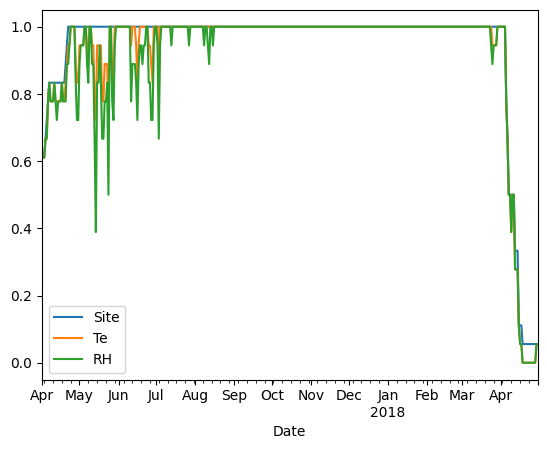

In [426]:
# FOR PLOTTING TEMPORALLY WHEN THE SENSOR NETWORK IS MISSING DATA

# # Get percentage of sensors with data for each day
# nan_percentage = all_combined['phase3'].groupby(['Date']).count()/len(all_combined['phase3']['Site'].unique())

# # Which dates are there less than 75% of sensors working?
# index_values = nan_percentage[nan_percentage['Te']<0.75].index

# # print(index_values)
# # # Make values nan if not enough data to interpolate
# # all_combined['phase3'].loc[index_values, 'Te'] = np.nan

# a=all_combined['phase3'].groupby(['Date']).count()/len(all_combined['phase3']['Site'].unique())

# a.plot()

# print(index_values)


In [ ]:
# OLD

# # Create range of all dates in bioscan data period
# date_range = pd.date_range(datetime.strptime(start_date, '%Y-%m-%d'), datetime.strptime(end_date, '%Y-%m-%d')).tolist()

# # create empty df to store outputs of IDW
# IDW_output = pd.DataFrame(columns=ranks.index.values.tolist(), index=date_range)
    
# for site in ranks.index.values.tolist():
#     for date in date_range:
#         station_rank = 1.0
#         num_selected = 0

#         # create empty df for distance (weights) and met variable values to be put for each of x number of sites used for IDW
#         date_values = pd.DataFrame(columns=["distance", "value"])
#         while num_selected < num_sites_IDW:
#             # get site name with rank equal to "station_rank" - starts at 1 and increases by 1 each iteration
#             my_station = ranks.loc[[site]].eq(station_rank, axis=0).idxmax(axis=1)
#             # skip this met station if date is not in dataset index
#             if date in station_data_dict[my_station[0]].index:
#                 # skip this met station if value is nan for date
#                 if bool(station_data_dict[my_station[0]].loc[[date], [datatypeid]].notna()[datatypeid][0]):
#                     date_values.loc[len(date_values.index)] = [dist_to_stations.loc[[site], [my_station[0]]][my_station[0]][0],station_data_dict[my_station[0]].loc[[date], [datatypeid]][datatypeid][0]] 
#                     # since this met station had data for this date, it counts towards one of the x number of stations that will be used to compute IDW for value
#                     num_selected += 1
#                 else:
#                     pass
#             else:
#                 pass

#             station_rank += 1

#         # IDW Calculation for site, date combo
#         date_values['weight'] = 1/(date_values['distance']**(IDW_power))
#         date_values['IDW_top'] = date_values['value'].astype(float) * date_values['weight']
#         IDW_value = date_values.sum()['IDW_top']/date_values.sum()['weight']

#         # store IDW value for site, date into IDW_output dataframe
#         IDW_output.loc[date,site] = IDW_value
#     print(f'Done with {site}')

    
# # Calculate annual mean and standard deviation for both temp and RH

# aggregated_dfs = {}

# aggregated_dfs['phase1'] = all_combined['phase1'].groupby(["Site"]).mean()
# aggregated_dfs['phase1']['Temp_std'] = all_combined['phase1'].groupby(["Site"]).std()['Te']
# aggregated_dfs['phase1']['RH_std'] = all_combined['phase1'].groupby(["Site"]).std()['RH']

# aggregated_dfs['phase2'] = all_combined['phase2'].groupby(["Site"]).mean()
# aggregated_dfs['phase2']['Temp_std'] = all_combined['phase2'].groupby(["Site"]).std()['Te']
# aggregated_dfs['phase2']['RH_std'] = all_combined['phase2'].groupby(["Site"]).std()['RH']

# aggregated_dfs['phase3'] = all_combined['phase3'].groupby(["Site"]).mean()
# aggregated_dfs['phase3']['Temp_std'] = all_combined['phase3'].groupby(["Site"]).std()['Te']
# aggregated_dfs['phase3']['RH_std'] = all_combined['phase3'].groupby(["Site"]).std()['RH']

# aggregated_dfs = pd.concat([aggregated_dfs['phase2'], aggregated_dfs['phase3']])

# aggregated_dfs.to_csv(os.path.join(os.getcwd(), 'data', 'ibutton_annual_agg.csv'))